## **Pretraitement:**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Using GPU

In [20]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import MSELoss
from torch.optim import Adam, SGD, Adadelta, Adagrad
import matplotlib.pyplot as plt
import numpy as np


torch.manual_seed(42)


In [21]:
# Setting device on GPU if available, else MPS (Apple M1) or CPU
if torch.cuda.is_available():
     device = torch.device('cuda') # CUDA backend for NVIDIA or AMD graphic cards
else:
    try:
        if torch.backends.mps.is_available():
            device = torch.device('mps') # MPS for Apple M# processors
        else:
            device = torch.device('cpu')
    except AttributeError:
        device = torch.device('cpu')

print('Using device:', device)
print()

# Additional info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cpu


#**Définition des données de l'experience 1 et 2:**

In [22]:
import torch
# Voir dans utils prob.py fonction measure, gen_samples et random_A


# Define A as standard Gaussian :
m = 250
n = 500
A = torch.normal(torch.zeros([m,n]), torch.tensor([1.0/m]))

  # Normalize colums to have unit l2 norm:
A = A.detach().clone().to(device)
for i in range(A[0,:].shape[0]):
  norm_column = torch.norm(A[:, i], 2)
  A[:,i] /= norm_column

  #Gram matrix and max eigenvalue:
def max_eig(A):
  gram_A = torch.matmul(A.transpose(0,1),A)
  eigenvalues, eigenvectors = torch.linalg.eig(gram_A)
  L = torch.max(torch.abs(eigenvalues))
  return(gram_A, L)

gram_A, L = max_eig(A)
L *= 1.01

# Samples definition:
SNR = 30.
def gen_samples(nb_samples, noise=False):
  X_target = torch.normal(torch.zeros([nb_samples, n]), torch.tensor([1])).to(device)
    # Samples sparse :
  eps = torch.zeros([nb_samples, m], device = device)
  pb = 0.1
  coin = torch.bernoulli(pb*torch.ones([nb_samples, n])).to(device)
  X_target = X_target*coin

  if noise:
    eps = torch.normal(torch.zeros([nb_samples, m]), torch.pow(torch.tensor(10.0), torch.tensor(-SNR/20.0))).to(device)
  # Observed value:
  X_observed = torch.matmul(X_target, A.transpose(0,1)) + eps
  return(torch.utils.data.TensorDataset(X_observed, X_target.requires_grad_(True), torch.arange(nb_samples)))


In [23]:
#Train data et test data:
nb_samples_train = 1000
train_data = gen_samples(nb_samples_train)
test_data = gen_samples(nb_samples_train)

# Taille des données:
var_names = ['X_observed', 'X_target', 'id']
for i, var_name in enumerate(var_names):
  print(f'{var_name}={train_data[:][i].shape}')

  #  Taille gram et L:
  print(gram_A.shape, L.shape)


'%%%%% With noise %%%%'
#Train data et test data:
nb_samples_train = 1000
train_data_noisy = gen_samples(nb_samples_train, noise = True)
test_data_noisy = gen_samples(nb_samples_train, noise = True)


X_observed=torch.Size([1000, 250])
torch.Size([500, 500]) torch.Size([])
X_target=torch.Size([1000, 500])
torch.Size([500, 500]) torch.Size([])
id=torch.Size([1000])
torch.Size([500, 500]) torch.Size([])


In [24]:
# Save datasets
torch.save(train_data, 'train_data.pt')
torch.save(test_data, 'test_data.pt')
torch.save(train_data_noisy, 'train_data_noisy.pt')
torch.save(test_data_noisy, 'test_data_noisy.pt')
torch.save(A, 'A.pt')


In [7]:

# Load datasets
train_data = torch.load('train_data.pt')
test_data = torch.load('test_data.pt')
train_data_noisy = torch.load('train_data_noisy.pt')
test_data_noisy = torch.load('test_data_noisy.pt')
A = torch.load('A.pt')

# **Trainer, PSNR:**

In [25]:
import time

class Trainer():
    def __init__(self,
                 model, optimizer, scheduler, loss,
                 train_dataloader, val_dataloader=None, check_val_every_n_epoch=1, verbose=True):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.loss = loss
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.check_val_every_n_epoch = check_val_every_n_epoch
        self.metrics = Metrics()
        self.history = {}
        self.epoch = 0
        self.verbose = verbose

    def run(self, num_epoch):
        """ Run training until the given number of epochs is reached """
        try:
            # Progress bar
            from tqdm.notebook import tqdm
            training_pbar = tqdm(
                iterable=range(self.epoch, num_epoch),
                initial=self.epoch,
                total=num_epoch,
                desc="Training",
                unit="epoch"
            )

            for _ in training_pbar:
                self.training_epoch()
                training_pbar.set_postfix(self.history["Training"][-1][1])
                if self.epoch % self.check_val_every_n_epoch == 0:
                    self.validation_epoch()
                    epoch, metrics = self.history["Validation"][-1]
                    if self.verbose:
                      print(f"Validation epoch {epoch:4d} | " + " | ".join((f"{k}: {v:.2e}" for k, v in metrics.items())))


        except KeyboardInterrupt:
            """ Stop training if Ctrl-C is pressed """
            pass

    def training_epoch(self):
        """ Train for one epoch """
        device = self.device
        self.metrics.init()
        for x, target, *_ in self.train_dataloader:
            x = x.to(device)
            target = target.to(device)

            y = self.model(x)
            loss = self.loss(y, target)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.model.threshold.data = self.model.threshold.data.clamp(min=0)
            self.metrics.accumulate(loss, x, y, target)

        self.epoch += 1
        self.log("Training", self.epoch, self.metrics.summarize())


    def validation_epoch(self):
        """ Run a validation step """
        if self.val_dataloader is None:
            return

        device = self.device
        self.metrics.init()
        with torch.no_grad():
            for x, target, *_ in self.val_dataloader:
                x = x.to(device)
                target = target.to(device)

                y = self.model(x)
                loss = self.loss(y, target)
                if self.scheduler != False:
                  self.scheduler.step(loss)  # ajout
                self.metrics.accumulate(loss, x, y, target)

        self.log("Validation", self.epoch, self.metrics.summarize())

    def log(self, mode, epoch, metrics):
        history = self.history.setdefault(mode, [])
        history.append((epoch, metrics))
        #print(f"{mode} epoch {epoch:4d} | " + " | ".join((f"{k}: {v:.2e}" for k, v in metrics.items())))

    @property
    def device(self):
        """ Training device defined from the device of the first parameter of the model """
        return next(self.model.parameters()).device


class Metrics:
    """ Calculate metrics from training and validation steps """
    def init(self):
        self.metrics = dict()
        self.cnt = 0
        self.tic = time.perf_counter()

    def accumulate(self, loss, x, y, target):
        with torch.no_grad():
            self.metrics["Loss"] = self.metrics.get("Loss", 0) + loss.item()
            self.metrics["PSNR"] = self.metrics.get("PSNR", 0) + PSNR(y, target).mean().item()
            #self.metrics["SNR"] = self.metrics.get("SNR", 0) + SNR(y, target).mean().item()
        self.cnt += 1

    def summarize(self):
        self.toc = time.perf_counter()
        metrics = {k: v / self.cnt for k, v in self.metrics.items()}
        metrics["Wall time"] = self.toc - self.tic
        return metrics

**PSNR SNR:**

In [26]:
def PSNR(img1, img2):
    # Optional: get last 3 dimensions (CxNxM) so that to be compatible with single sample
    #dims = list(range(max(0, img1.ndim - 3), img1.ndim))
    # otherwise simply
    dims = list(range(1, img1.ndim))

    # Take care to the mean along only the last 3 dimensions.
    return 10 * torch.log10(1. / (img1 - img2).pow(2).mean(dims))

def SNR(img1, img2):
    dims = list(range(1, img1.ndim))
    return 20 * torch.log2(1. / (img1 - img2).pow(2).mean(dims))


# **Implémentation de ISTA et FISTA pour comparaisons:**

#### **Définition des modèles:**

In [27]:
class Forward_Backward():
  def __init__(self, size_observed, size_target, A, lambd = 0.1, Niter = 16):
    self.A = A
    gram_A, L = max_eig(self.A)
    self.gram_A = gram_A
    self.L = L * 1.001
    self.tau = 1/L
    self.lambd = lambd
    self.Niter = Niter
    self.size_observed = size_observed
    self.size_target = size_target

  def __shrink__(self, x):
    return torch.sign(x) * (torch.abs(x) -self.lambd*self.tau)

  def iterations(self, x):
    u = torch.zeros((x.shape[0], size_target)).to(device)
    for  i in  range(self.Niter):
            u = self.__shrink__(u + torch.matmul(x-torch.matmul(u, self.A.transpose(0,1)), self.A)/self.L)
    return u

  def __partial_forward__(self, x):
    u = torch.zeros((x.shape[0], size_target)).to(device)
    partials_u = [u]
    for i in range(self.Niter):
      u = self.__shrink__(u + torch.matmul(x-torch.matmul(u, self.A.transpose(0,1)), self.A)/self.L)
      partials_u.append(u)
    return partials_u

  def __partial_NMSE__(self, x, y):
    partials_u = self.__partial_forward__(x)
    partials_NMSE = []
    for partial_u in partials_u:
      partial_error = partial_u - y
      norm_error = torch.norm(partial_error, p = 2, dim = 1)**2
      norm_x = torch.norm(x, p=2, dim = 1)**2
      partials_NMSE.append(10*torch.log10(torch.mean(norm_error)/torch.mean(norm_x)))
    return(partials_NMSE)

'''%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%'''

class Fast_Forward_Backward():
  def __init__(self, size_observed, size_target, A, lambd = 0.1, Niter = 16):
    self.A = A

    gram_A, L = max_eig(self.A)
    self.gram_A = gram_A
    self.L = L * 1.001
    self.tau = 1/L
    self.lambd = lambd
    self.Niter = Niter
    self.size_observed = size_observed
    self.size_target = size_target

  def __shrink__(self, x):
    return torch.sign(x) * (torch.abs(x) -self.lambd/self.L)

  def iterations(self, x):
    u = torch.zeros((x.shape[0], size_target)).to(device)
    v = u
    t=1

    for  i in  range(self.Niter):
            u0 = u
            #u = self.__shrink__(v)
            u = self.__shrink__(v + torch.matmul(x-torch.matmul(v, self.A.transpose(0,1)), self.A)/self.L)
            t_next = (1+np.sqrt(1+4*t**2))/2
            v = u + (t-1)/(t_next)*(u - u0)
            t = t_next
    return u

  def __partial_forward__(self, x):
    u = torch.zeros((x.shape[0], size_target)).to(device)
    v = u
    t=1

    partials_u = [u]
    for i in range(self.Niter):
      u0 = u
      u = self.__shrink__(v + torch.matmul(x-torch.matmul(v, self.A.transpose(0,1)), self.A)/self.L)
      t_next = (1+np.sqrt(1+4*t**2))/2
      v = u + (t-1)/(t_next)*(u - u0)
      t= t_next
      partials_u.append(u)
    return partials_u

  def __partial_NMSE__(self, x, y):
    partials_u = self.__partial_forward__(x)
    partials_NMSE = []
    for partial_u in partials_u:
      partial_error = partial_u - y
      norm_error = torch.norm(partial_error, p = 2, dim = 1)**2
      norm_x = torch.norm(x, p=2, dim = 1)**2
      partials_NMSE.append(10*torch.log10(torch.mean(norm_error)/torch.mean(norm_x)))
    return(partials_NMSE)

'''%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%'''

class Forward_Backward_adaptative():
  def __init__(self, size_observed, size_target, A, lambd = 0.2, Niter = 16):
    self.A = A
    gram_A, L = max_eig(self.A)
    self.gram_A = gram_A
    self.L = L * 1.001
    self.tau = 1/L
    self.lambd = lambd
    self.Niter = Niter
    self.size_observed = size_observed
    self.size_target = size_target
    self.tol = 10**(-5)
    self.converged = 10**(-3)
    self.eps = 0.05
  def __shrink__(self, x):
    return torch.sign(x) * (torch.abs(x) -self.lambd*self.tau)

  def iterations(self, x, y):
    u = torch.zeros((x.shape[0], self.size_target)).to(device)
    MSE_list = [0]
    for  i in  range(self.Niter):
      u0 = u
      u = self.__shrink__(u + torch.matmul(x-torch.matmul(u, self.A.transpose(0,1)), self.A)/self.L)
      #adaptative part:
      norm_x = torch.norm(u - u0, p=2, dim = 1)
      if i > 0:
        if norm_x < self.eps:
          self.lambd = self.lambd *0.5
          self.eps = 0.5*self.eps
    return u

  def __partial_forward__(self, x, y):
    u = torch.zeros((x.shape[0], self.size_target)).to(device)
    partials_u = [u.detach().clone()]
    MSE_list = [0]
    for i in range(self.Niter):
      u0 = u.detach().clone()
      u = self.__shrink__(u + torch.matmul(x-torch.matmul(u, self.A.transpose(0,1)), self.A)/self.L)
      partials_u.append(u)

      #adaptative part:
      norm_x = torch.norm(u - u0, p=2, dim = 1)
      if i > 0:
        print(norm_x.shape, u.shape)
        if norm_x < self.eps:
          self.lambd = self.lambd *0.5
          self.eps = 0.5*self.eps

    return partials_u

  def __partial_NMSE__(self, x, y):
    partials_u = self.__partial_forward__(x, y)
    partials_NMSE = []
    for partial_u in partials_u:
      partial_error = partial_u - y
      norm_error = torch.norm(partial_error, p = 2, dim = 1)**2
      norm_x = torch.norm(x, p=2, dim = 1)**2
      partials_NMSE.append(10*torch.log10(torch.mean(norm_error)/torch.mean(norm_x)))
    return(partials_NMSE)


#### **Test:**

In [28]:
#nb_samples = train_data[:][0].shape[0]
nb_samples = len(train_data)
size_target = train_data[:][1].shape[1]
size_observed = train_data[:][0].shape[1]

# Create the neural network and move it to the computational device
fb_model = Forward_Backward( size_observed=size_observed, size_target=size_target, A=A)
ffb_model = Fast_Forward_Backward( size_observed=size_observed, size_target=size_target, A=A)
# Create the DataLoader and configure mini-batching
batch_size = nb_samples
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

fb_model.__partial_NMSE__(train_data[:][0], train_data[:][1]), ffb_model.__partial_NMSE__(train_data[:][0], train_data[:][1])


([tensor(-0.0040, grad_fn=<MulBackward0>),
  tensor(-1.2893, grad_fn=<MulBackward0>),
  tensor(-1.9149, grad_fn=<MulBackward0>),
  tensor(-2.3442, grad_fn=<MulBackward0>),
  tensor(-2.6849, grad_fn=<MulBackward0>),
  tensor(-2.9768, grad_fn=<MulBackward0>),
  tensor(-3.2386, grad_fn=<MulBackward0>),
  tensor(-3.4801, grad_fn=<MulBackward0>),
  tensor(-3.7075, grad_fn=<MulBackward0>),
  tensor(-3.9238, grad_fn=<MulBackward0>),
  tensor(-4.1320, grad_fn=<MulBackward0>),
  tensor(-4.3340, grad_fn=<MulBackward0>),
  tensor(-4.5303, grad_fn=<MulBackward0>),
  tensor(-4.7222, grad_fn=<MulBackward0>),
  tensor(-4.9106, grad_fn=<MulBackward0>),
  tensor(-5.0957, grad_fn=<MulBackward0>),
  tensor(-5.2783, grad_fn=<MulBackward0>)],
 [tensor(-0.0040, grad_fn=<MulBackward0>),
  tensor(-1.2893, grad_fn=<MulBackward0>),
  tensor(-1.9149, grad_fn=<MulBackward0>),
  tensor(-2.4605, grad_fn=<MulBackward0>),
  tensor(-2.9608, grad_fn=<MulBackward0>),
  tensor(-3.4429, grad_fn=<MulBackward0>),
  tensor(-

# **Implémentation de l'expérience 1 avec LISTA (artificial data) :**

#### **Définition du modele:**

In [29]:
# Voir models LISTA, setup_layers

class LISTA_model(torch.nn.Module):
  def __init__(self, size_observed, size_target, A, depth=16, init = True):
    super().__init__()
    from torch.nn import ModuleList, Flatten, Linear, ReLU, parameter
    # Quelques attributs:
    self.A = A
    gram_A, L = max_eig(self.A)
    self.gram_A = gram_A
    self.L = L * 1.001

    self.depth = depth
    self.size_observed = size_observed
    self.size_target = size_target

    #rates of Thresholds:
    if init:
      self.threshold = parameter.Parameter(torch.ones([self.depth], dtype=torch.float32).to(device)/self.L).to(device)
      #self.param_group = [{"params": self.threshold, "l1_proj": lambda x: x.clamp(min=0)}]
    else:
      self.threshold = parameter.Parameter(torch.randn(self.depth))
      #self.param_groups = [{"params": self.threshold, "l1_proj": lambda x: x.clamp(min=0)}]

    #Weights and Biases:
    self.bias_layers = ModuleList()
    self.weight_layers = ModuleList()
    for i in range(depth):
      # Init weight_layers & bias_layers
      weight_layer = Linear(size_target, size_target, bias=False)
      bias_layer = Linear(size_observed, size_target, bias=False)

      if init:
        weight_layer.weight = nn.Parameter(torch.eye(self.size_target).to(device) - self.gram_A/self.L)
        bias_layer.weight = nn.Parameter(self.A.transpose(0,1)/self.L)


      self.weight_layers.append(weight_layer.to(device))
      self.bias_layers.append(bias_layer.to(device))

  def __shrink__(self, x, threshold):
        #return torch.sign(x) * torch.max(torch.abs(x) - torch.max(threshold, torch.tensor([0.]).to(device)), torch.zeros_like(x))
        return torch.sign(x) * (torch.abs(x) - threshold).clamp(min=0.)

  def forward(self, x):

    u = torch.zeros((x.shape[0], size_target)).to(device)

    for  weight, bias, i in  zip(self.weight_layers, self.bias_layers, range(self.depth)):
            # print('l 54 lista', torch.unique(u))
            u = self.__shrink__(weight(u) + bias(x), self.threshold[i])
    return u

  def __partial_forward__(self, x):
    u = torch.zeros((x.shape[0], size_target)).to(device)
    partials_u = [u]
    for  weight, bias, i in  zip(self.weight_layers, self.bias_layers, range(self.depth)):
            u = self.__shrink__(weight(u) + bias(x), self.threshold[i])
            partials_u.append(u)
    return partials_u

  # def __partial_NMSE__(self, x, y):
  #   partials_u = self.__partial_forward__(x)
  #   partials_NMSE = []
  #   for partial_u in partials_u:
  #     partial_error = partial_u - y
  #     norm_error = torch.norm(partial_error, p = 2, dim = 1)**2
  #     norm_x = torch.norm(x, p=2, dim = 1)**2
  #     partials_NMSE.append(10*torch.log10(torch.mean(norm_error)/torch.mean(norm_x)))
  #   return(partials_NMSE)

  def __partial_NMSE__(self, x, y):
      partials_u = self.__partial_forward__(x)
      partials_NMSE = []
      for partial_u in partials_u:
        partial_error = partial_u - y
        norm_error = torch.norm(partial_error, p = 2, dim = 1)**2
        norm_x = torch.norm(x, p=2, dim = 1)**2
        partials_NMSE.append(10*torch.log10(torch.mean(norm_error)/torch.mean(norm_x)))
      return(partials_NMSE)





In [30]:
# Set the seed for CPU

loss = nn.MSELoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
print(loss(input, target))

tensor(2.4102, grad_fn=<MseLossBackward0>)


#### **Entrainement:**

In [31]:

#nb_samples = train_data[:][0].shape[0]
nb_samples = len(train_data)
size_target = train_data[:][1].shape[1]
size_observed = train_data[:][0].shape[1]

# Create the neural network and move it to the computational device
Lista_model = LISTA_model( size_observed=size_observed, size_target=size_target, A=A, depth=16, init=True).to(device)
Lista_model_noisy = LISTA_model( size_observed=size_observed, size_target=size_target, A=A, depth=16, init=True).to(device)
print("Number of parameters:", sum(w.numel() for w in Lista_model.parameters()))

# Create the DataLoader and configure mini-batching
batch_size = nb_samples
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_dataloader_noisy = DataLoader(train_data_noisy, batch_size=batch_size, shuffle=True)
val_dataloader_noisy = DataLoader(test_data_noisy, batch_size=batch_size, shuffle=True)

# Initialize loss, optimizer and trainer
loss = MSELoss()
# optimizer = Adam(Lista_model.parameters(), lr=1e-5)
optimizer = Adadelta(Lista_model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0, foreach=None, maximize=False)
#optimizer = Adagrad(Lista_model.parameters(), lr=0.001)
#optimizer = SGD(Lista_model.parameters(), lr=0.01, momentum=0.9)

#optimizer_noisy = Adam(Lista_model_noisy.parameters(), lr=1e-3)
optimizer_noisy = Adadelta(Lista_model_noisy.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0, foreach=None, maximize=False)
#optimizer_noisy = Adagrad(Lista_model_noisy.parameters(), lr=0.001)
#optimizer_noisy = SGD(Lista_model_noisy.parameters(), lr=0.01, momentum=0.9)

scheduler = False
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)
Lista_trainer = Trainer(Lista_model, optimizer, scheduler, loss,
                  train_dataloader, val_dataloader, check_val_every_n_epoch=100)
Lista_trainer_noisy = Trainer(Lista_model_noisy, optimizer_noisy, scheduler, loss,
                  train_dataloader_noisy, val_dataloader_noisy, check_val_every_n_epoch=100)
# # Run training
print(Lista_model.threshold)
Lista_trainer.run(1200)
print(Lista_model.threshold)

print(Lista_model_noisy.threshold)
Lista_trainer_noisy.run(1200)
print(Lista_model_noisy.threshold)


Number of parameters: 6000016
Parameter containing:
tensor([0.1764, 0.1764, 0.1764, 0.1764, 0.1764, 0.1764, 0.1764, 0.1764, 0.1764,
        0.1764, 0.1764, 0.1764, 0.1764, 0.1764, 0.1764, 0.1764],
       requires_grad=True)


Training:   0%|          | 0/1200 [00:00<?, ?epoch/s]

Validation epoch  100 | Loss: 1.86e-02 | PSNR: 1.77e+01 | Wall time: 2.53e-01
Parameter containing:
tensor([0.1303, 0.1114, 0.0963, 0.0843, 0.0743, 0.0661, 0.0592, 0.0532, 0.0478,
        0.0430, 0.0385, 0.0343, 0.0302, 0.0256, 0.0198, 0.0029],
       requires_grad=True)
Parameter containing:
tensor([0.1764, 0.1764, 0.1764, 0.1764, 0.1764, 0.1764, 0.1764, 0.1764, 0.1764,
        0.1764, 0.1764, 0.1764, 0.1764, 0.1764, 0.1764, 0.1764],
       requires_grad=True)


Training:   0%|          | 0/1200 [00:00<?, ?epoch/s]

Validation epoch  100 | Loss: 1.82e-02 | PSNR: 1.77e+01 | Wall time: 2.38e-01
Validation epoch  200 | Loss: 1.79e-02 | PSNR: 1.78e+01 | Wall time: 2.42e-01
Validation epoch  300 | Loss: 1.77e-02 | PSNR: 1.79e+01 | Wall time: 2.62e-01
Validation epoch  400 | Loss: 1.76e-02 | PSNR: 1.79e+01 | Wall time: 3.48e-01
Validation epoch  500 | Loss: 1.75e-02 | PSNR: 1.80e+01 | Wall time: 3.04e-01
Validation epoch  600 | Loss: 1.74e-02 | PSNR: 1.80e+01 | Wall time: 2.78e-01
Validation epoch  700 | Loss: 1.73e-02 | PSNR: 1.81e+01 | Wall time: 3.36e-01
Validation epoch  800 | Loss: 1.72e-02 | PSNR: 1.81e+01 | Wall time: 3.04e-01
Validation epoch  900 | Loss: 1.72e-02 | PSNR: 1.81e+01 | Wall time: 2.91e-01
Validation epoch 1000 | Loss: 1.72e-02 | PSNR: 1.81e+01 | Wall time: 3.38e-01
Validation epoch 1100 | Loss: 1.72e-02 | PSNR: 1.81e+01 | Wall time: 2.45e-01
Validation epoch 1200 | Loss: 1.71e-02 | PSNR: 1.81e+01 | Wall time: 3.30e-01
Parameter containing:
tensor([0.1228, 0.1036, 0.0891, 0.0775, 0.

In [ ]:
print(Lista_model.threshold)
Lista_trainer.run(10000)
print(Lista_model.threshold)

#### **Affichage de la loss et du PSNR:**

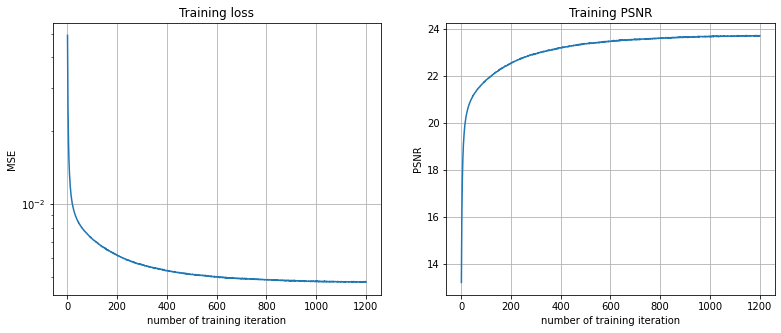

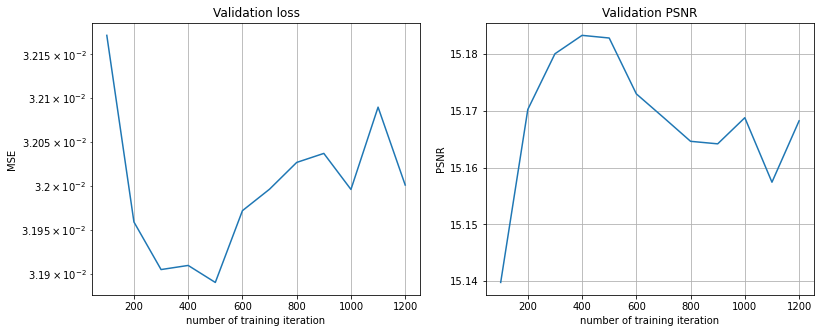

train loss: 0.004779499489814043 --- validation loss: 0.032041218131780624


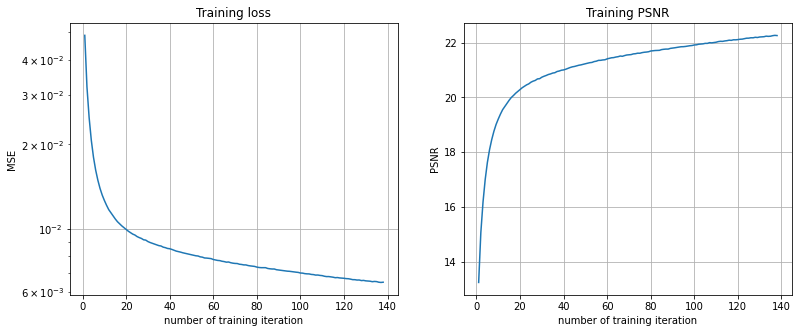

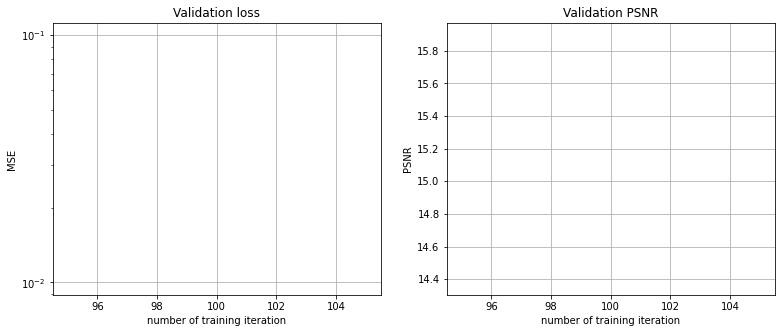

train loss: 0.006453145295381546 --- validation loss: 0.032041218131780624


In [ ]:
import matplotlib.pyplot as plt

# Learning curve
for mode in Lista_trainer.history.keys():
    data = dict()
    for epoch, record in Lista_trainer.history[mode]:
        data.setdefault("epoch", []).append(epoch)
        for metric, value in record.items():
            data.setdefault(metric, []).append(value)

    plt.figure(figsize=(20, 5))
    plt.subplot(131)
    plt.semilogy(data["epoch"], data["Loss"])
    plt.title(f"{mode} loss")
    plt.xlabel('number of training iteration')
    plt.ylabel('MSE')
    plt.grid()

    plt.subplot(132)
    plt.plot(data["epoch"], data["PSNR"])
    plt.title(f"{mode} PSNR")
    plt.xlabel('number of training iteration')
    plt.ylabel('PSNR')
    plt.grid()

    # plt.subplot(133)
    # plt.plot(data["epoch"], data["SNR"])
    # plt.title(f"{mode} SNR")
    # plt.grid()

    plt.show()
print(f'train loss: {loss(Lista_model(train_data[:][0]), train_data[:][1])} --- validation loss: {loss(Lista_model(test_data[:][0]), test_data[:][1])}')


'%%%%%% Noisy training curves %%%%%'
# Learning curve
for mode in Lista_trainer_noisy.history.keys():
    data = dict()
    for epoch, record in Lista_trainer_noisy.history[mode]:
        data.setdefault("epoch", []).append(epoch)
        for metric, value in record.items():
            data.setdefault(metric, []).append(value)

    plt.figure(figsize=(20, 5))
    plt.subplot(131)
    plt.semilogy(data["epoch"], data["Loss"])
    plt.title(f"{mode} loss")
    plt.xlabel('number of training iteration')
    plt.ylabel('MSE')
    plt.grid()

    plt.subplot(132)
    plt.plot(data["epoch"], data["PSNR"])
    plt.title(f"{mode} PSNR")
    plt.xlabel('number of training iteration')
    plt.ylabel('PSNR')
    plt.grid()

    # plt.subplot(133)
    # plt.plot(data["epoch"], data["SNR"])
    # plt.title(f"{mode} SNR")
    # plt.grid()

    plt.show()
print(f'train loss: {loss(Lista_model_noisy(train_data_noisy[:][0]), train_data_noisy[:][1])} --- validation loss: {loss(Lista_model(test_data[:][0]), test_data[:][1])}')



In [ ]:

# sauvegarder les modèles
torch.save(Lista_model.state_dict(), '/content/drive/MyDrive/Data/LISTA/Lista_model.pth')
torch.save(Lista_model_noisy.state_dict(), '/content/drive/MyDrive/Data/LISTA/Lista_model_noisy.pth')

# sauvegarder l'historique d'entraînement
torch.save(Lista_trainer.history, '/content/drive/MyDrive/Data/LISTA/Lista_trainer_history.pth')
torch.save(Lista_trainer_noisy.history, '/content/drive/MyDrive/Data/LISTA/Lista_trainer_noisy_history.pth')

RuntimeError: ignored

In [ ]:
# charger les modèles
Lista_model = LISTA_model(size_observed=size_observed, size_target=size_target, A=A, depth=16, init=True).to(device)
Lista_model.load_state_dict(torch.load('/content/drive/MyDrive/Data/LISTA/Lista_model.pth'))
Lista_model_noisy = LISTA_model(size_observed=size_observed, size_target=size_target, A=A, depth=16, init=True).to(device)
Lista_model_noisy.load_state_dict(torch.load('/content/drive/MyDrive/Data/LISTA/Lista_model_noisy.pth'))


<All keys matched successfully>

#### **Validation du théorème 1:**

In [ ]:
with torch.no_grad():
    print(torch.matmul(Lista_model.bias_layers[i].weight, A).shape, Lista_model.weight_layers[i].weight.shape)
    list_parameters = list(Lista_model.parameters())
    thetas = Lista_model.threshold
    list_weights = [ Lista_model.weight_layers[i].weight - torch.eye(Lista_model.size_target).to(device) + torch.matmul(Lista_model.bias_layers[i].weight, A) for i in range(Lista_model.depth)]
    list_weights_norm = [torch.linalg.norm(list_weights[i]).detach().item() for i in range(len(list_weights))]
print(list_weights[0].shape, Lista_model.bias_layers[0].weight.shape )
'%%%% noisy data %%%%'
with torch.no_grad():
    list_parameters_noisy = list(Lista_model_noisy.parameters())
    thetas_noisy = Lista_model_noisy.threshold
    list_weights_noisy = [ Lista_model_noisy.weight_layers[i].weight - torch.eye(Lista_model.size_target).to(device) + torch.matmul(Lista_model_noisy.bias_layers[i].weight, A) for i in range(Lista_model_noisy.depth)]
    list_weights_norm_noisy = [torch.linalg.norm(list_weights_noisy[i], dim=(0,1), ord=2).detach().item() for i in range(len(list_weights_noisy))]

torch.Size([500, 500]) torch.Size([500, 500])
torch.Size([500, 500]) torch.Size([500, 250])


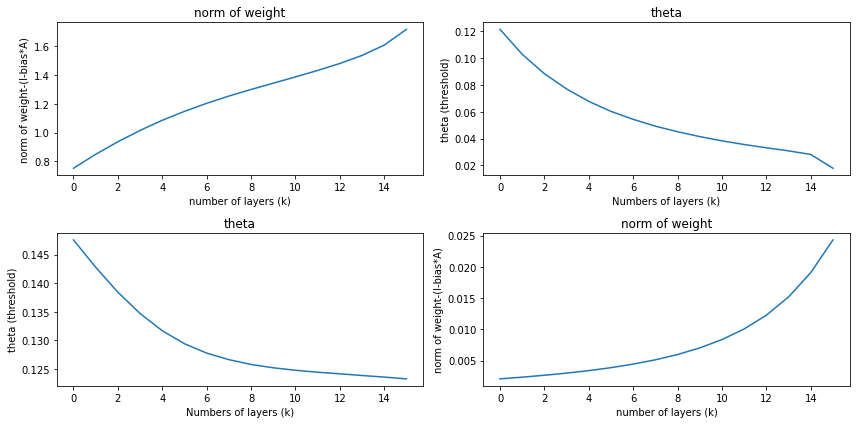

In [ ]:

fig = plt.figure(1, figsize=(12,6))
plt.subplot(222)
plt.plot(np.arange(Lista_model.depth), thetas.detach().cpu().numpy())
plt.title('theta')
plt.xlabel('Numbers of layers (k)')
plt.ylabel('theta (threshold)')

plt.subplot(221)
plt.plot(np.arange(Lista_model.depth), np.array(list_weights_norm))
plt.title('norm of weight')
plt.xlabel('number of layers (k)')
plt.ylabel('norm of weight-(I-bias*A)')



'%%%% noisy %%%%'
fig = plt.figure(1, figsize=(12,6))
plt.subplot(223)
plt.plot(np.arange(Lista_model_noisy.depth), thetas_noisy.detach().cpu().numpy())
plt.title('theta')
plt.xlabel('Numbers of layers (k)')
plt.ylabel('theta (threshold)')

plt.subplot(224)
plt.plot(np.arange(Lista_model_noisy.depth), np.array(list_weights_norm_noisy))
plt.title('norm of weight')
plt.xlabel('number of layers (k)')
plt.ylabel('norm of weight-(I-bias*A)')
plt.tight_layout()

#### **Selection du learning rate:**

learning rate: 0.0045


Training:   0%|          | 0/10000 [00:00<?, ?epoch/s]

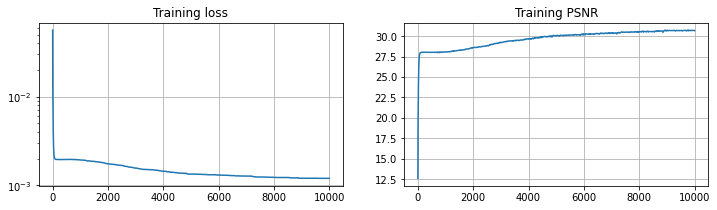

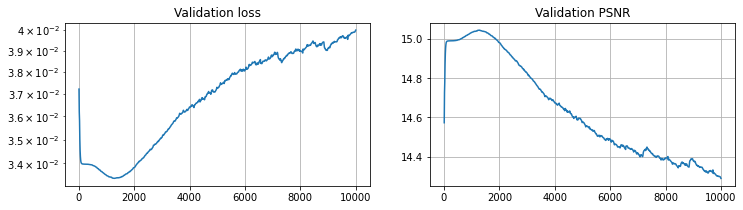

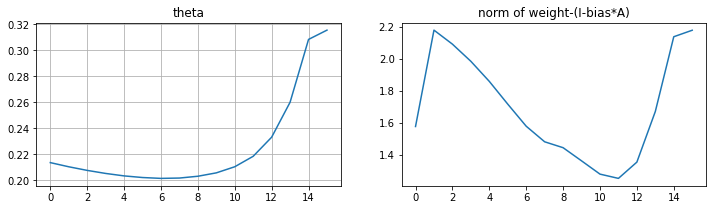

training loss: 0.0011961961863562465
learning rate: 0.005


Training:   0%|          | 0/10000 [00:00<?, ?epoch/s]

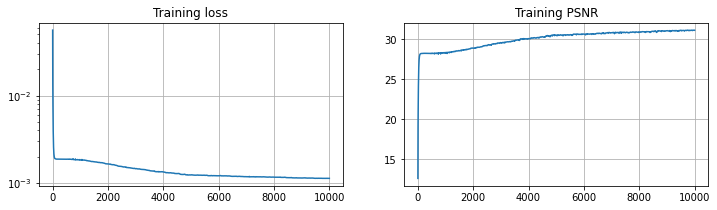

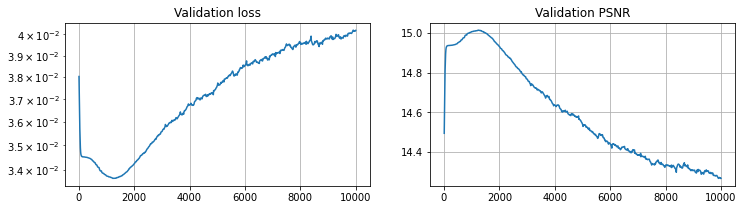

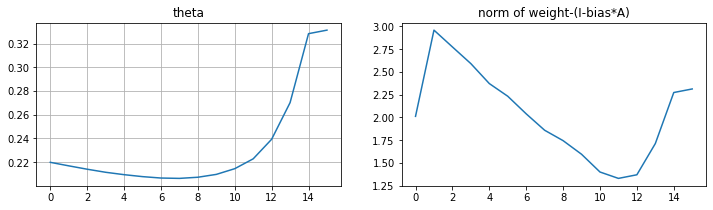

training loss: 0.0011270978720858693
learning rate: 0.0052


Training:   0%|          | 0/10000 [00:00<?, ?epoch/s]

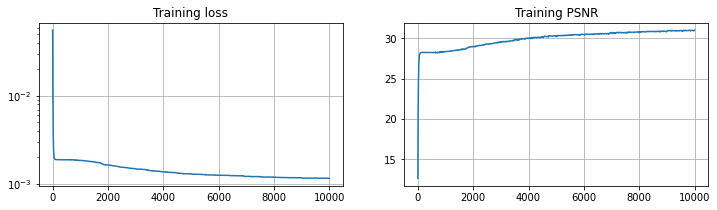

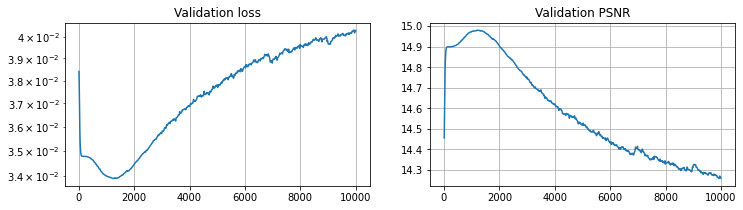

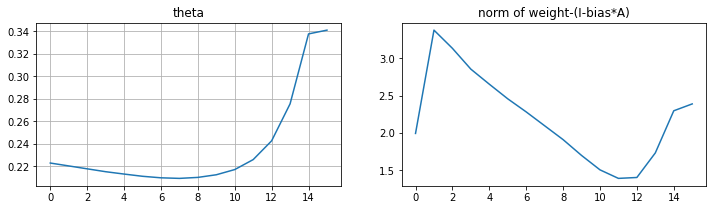

training loss: 0.0011521998094394803


In [ ]:
# torch.manual_seed(5117915234194007355)
nb_samples = train_data[:][0].shape[0]
size_target = train_data[:][1].shape[1]
size_observed = train_data[:][0].shape[1]

# Create the DataLoader and configure mini-batching
batch_size = int(nb_samples)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

lrs = [4.5e-3, 5e-3, 5.2e-3]

for lr in lrs:
  print(f'learning rate: {lr}')
  # Create the neural network and move it to the computational device
  Lista_model = LISTA_model( size_observed=size_observed, size_target=size_target, A=A, depth=16, init=True).to(device)

  # Initialize loss, optimizer and trainer
  loss = MSELoss()
  optimizer = Adam(Lista_model.parameters(), lr=lr)

  # reducing the learning rate?
  scheduler = False
  #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, min_lr=1e-5)

  Lista_trainer = Trainer(Lista_model, optimizer, scheduler, loss,
                    train_dataloader, val_dataloader, check_val_every_n_epoch=10, verbose = False)

  # Run epochs of training
  Lista_trainer.run(10000)

  # Learning curve
  for mode in Lista_trainer.history.keys():
      data = dict()
      for epoch, record in Lista_trainer.history[mode]:
          data.setdefault("epoch", []).append(epoch)
          for metric, value in record.items():
              data.setdefault(metric, []).append(value)

      plt.figure(figsize=(12, 3))
      plt.subplot(121)
      plt.semilogy(data["epoch"], data["Loss"])
      plt.title(f"{mode} loss")
      plt.xlabel('number of training iteration')
      plt.ylabel('MSE')
      plt.grid()

      plt.subplot(122)
      plt.plot(data["epoch"], data["PSNR"])
      plt.title(f"{mode} PSNR")
      plt.xlabel('number of training iteration')
      plt.ylabel('PSNR')
      plt.grid()

      plt.show()

  list_weights = [ Lista_model.weight_layers[i].weight - torch.eye(Lista_model.size_target).to(device) + torch.matmul(Lista_model.bias_layers[i].weight, A) for i in range(Lista_model.depth)]
  list_weights_norm = [torch.linalg.norm(list_weights[i], dim=(0,1), ord=2).detach().item() for i in range(len(list_weights))]

  fig = plt.figure(1, figsize=(12,3))
  plt.subplot(121)
  plt.plot(np.arange(Lista_model.depth), Lista_model.threshold.detach().clone().cpu().numpy())
  plt.title('theta')
  plt.xlabel('Numbers of layers (k)')
  plt.ylabel('theta (threshold)')
  plt.grid()
  plt.subplot(122)
  plt.plot(np.arange(Lista_model.depth), np.array(list_weights_norm))
  plt.title('norm of weight')
  plt.xlabel('number of layers (k)')
  plt.ylabel('norm of weight-(I-bias*A)')
  plt.show()

  print(f'training loss: {loss(Lista_model(train_data[:][0]), train_data[:][1])}')

**Initialisation aléatoire:**

learning rate: 0.0043


Training:   0%|          | 0/10000 [00:00<?, ?epoch/s]

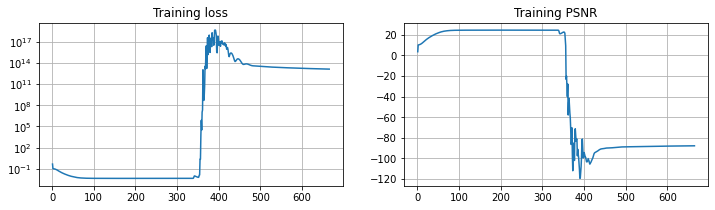

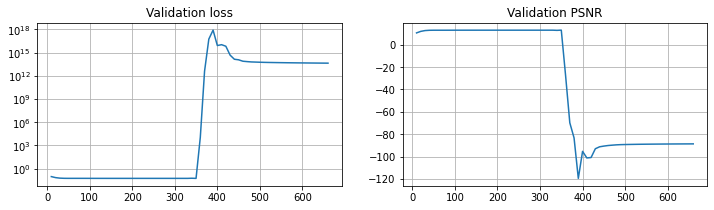

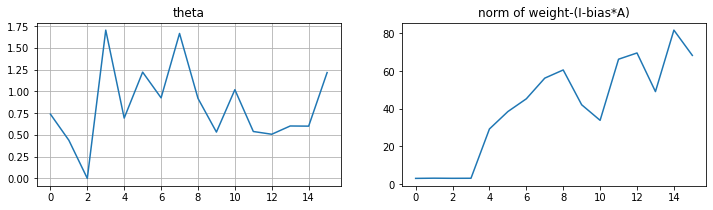

training loss: 13277634494464.0
learning rate: 0.0045


Training:   0%|          | 0/10000 [00:00<?, ?epoch/s]

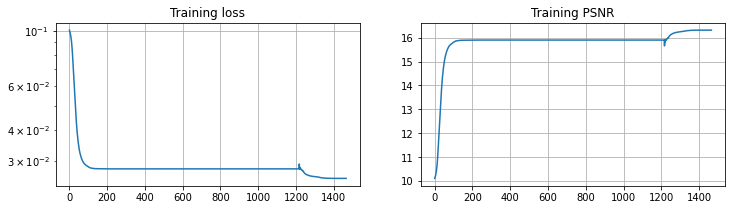

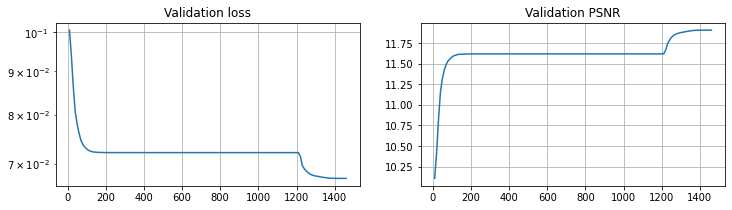

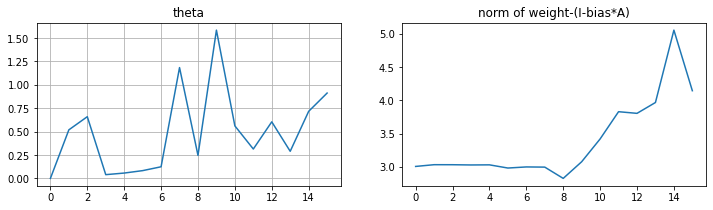

training loss: 0.02552640251815319
learning rate: 0.0047


Training:   0%|          | 0/10000 [00:00<?, ?epoch/s]

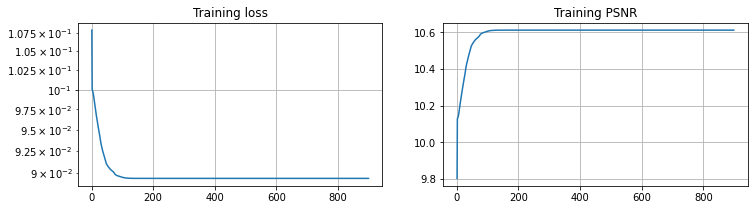

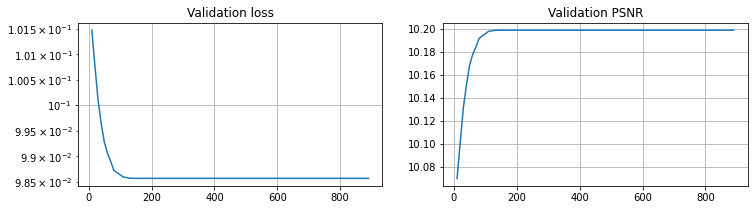

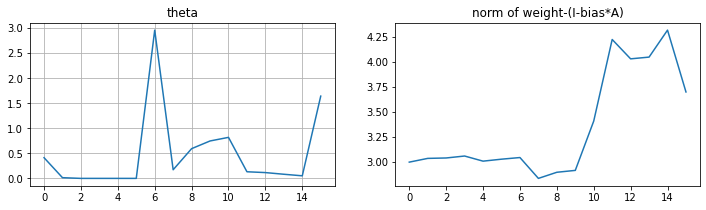

training loss: 0.08933351188898087


In [ ]:

# torch.manual_seed(5117915234194007355)
nb_samples = train_data[:][0].shape[0]
size_target = train_data[:][1].shape[1]
size_observed = train_data[:][0].shape[1]

# Create the DataLoader and configure mini-batching
batch_size = int(nb_samples)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

lrs = [4.3e-3, 4.5e-3, 4.7e-3]

for lr in lrs:
  print(f'learning rate: {lr}')
  # Create the neural network and move it to the computational device
  Lista_model = LISTA_model( size_observed=size_observed, size_target=size_target, A=A, depth=16, init=False).to(device)

  # Initialize loss, optimizer and trainer
  loss = MSELoss()
  optimizer = Adam(Lista_model.parameters(), lr=lr)

  # reducing the learning rate?
  scheduler = False
  #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, min_lr=1e-5)

  Lista_trainer = Trainer(Lista_model, optimizer, scheduler, loss,
                    train_dataloader, val_dataloader, check_val_every_n_epoch=10, verbose = False)

  # Run epochs of training
  Lista_trainer.run(10000)

  # Learning curve
  for mode in Lista_trainer.history.keys():
      data = dict()
      for epoch, record in Lista_trainer.history[mode]:
          data.setdefault("epoch", []).append(epoch)
          for metric, value in record.items():
              data.setdefault(metric, []).append(value)

      plt.figure(figsize=(12, 3))
      plt.subplot(121)
      plt.semilogy(data["epoch"], data["Loss"])
      plt.title(f"{mode} loss")
      plt.xlabel('number of training iteration')
      plt.ylabel('MSE')
      plt.grid()

      plt.subplot(122)
      plt.plot(data["epoch"], data["PSNR"])
      plt.title(f"{mode} PSNR")
      plt.xlabel('number of training iteration')
      plt.ylabel('PSNR')
      plt.grid()

      plt.show()

  list_weights = [ Lista_model.weight_layers[i].weight - torch.eye(Lista_model.size_target).to(device) + torch.matmul(Lista_model.bias_layers[i].weight, A) for i in range(Lista_model.depth)]
  list_weights_norm = [torch.linalg.norm(list_weights[i], dim=(0,1), ord=2).detach().item() for i in range(len(list_weights))]

  fig = plt.figure(1, figsize=(12,3))

  plt.subplot(121)
  plt.plot(np.arange(Lista_model.depth), Lista_model.threshold.detach().clone().cpu().numpy())
  plt.title('theta')
  plt.xlabel('Numbers of layers (k)')
  plt.ylabel('theta (threshold)')
  plt.grid()

  plt.subplot(122)
  plt.plot(np.arange(Lista_model.depth), np.array(list_weights_norm))
  plt.title('norm of weight')
  plt.xlabel('number of layers (k)')
  plt.ylabel('norm of weight-(I-bias*A)')
  plt.show()

  print(f'training loss: {loss(Lista_model(train_data[:][0]), train_data[:][1])}')

# **Implementation de LISTA CP:**

#### **Définition modèle:**

In [ ]:
class LISTACP_model(torch.nn.Module):
  def __init__(self, size_observed, size_target, A, depth=16, init = True):
    super().__init__()
    from torch.nn import ModuleList, Flatten, Linear, ReLU, parameter
    # Quelques attributs:
    self.A = A
    gram_A, L = max_eig(self.A)
    self.gram_A = gram_A
    self.L = L * 1.001

    self.depth = depth
    self.size_observed = size_observed
    self.size_target = size_target

    #rates of Thresholds:
    if init:
      self.threshold = parameter.Parameter(torch.ones([self.depth], dtype=torch.float32).to(device)/self.L).to(device)
      #self.param_group = [{"params": self.threshold, "l1_proj": lambda x: x.clamp(min=0)}]
    else:
      self.threshold = parameter.Parameter(torch.randn(self.depth))
      #self.param_groups = [{"params": self.threshold, "l1_proj": lambda x: x.clamp(min=0)}]

    #Weights and Biases:
    self.bias_layers = ModuleList()
    for i in range(depth):
      # Init weight_layers & bias_layers
      bias_layer = Linear(size_observed, size_target, bias=False)

      if init:
        bias_layer.weight = nn.Parameter(self.A.transpose(0,1)/self.L)

      self.bias_layers.append(bias_layer.to(device))

  def __shrink__(self, x, threshold):
        #return torch.sign(x) * torch.max(torch.abs(x) - torch.max(threshold, torch.tensor([0.]).to(device)), torch.zeros_like(x))
        return torch.sign(x) * (torch.abs(x) - threshold).clamp(min=0.)

  def forward(self, x):

    u = torch.zeros((x.shape[0], size_target)).to(device)

    for  bias, i in  zip(self.bias_layers, range(self.depth)):
            u = self.__shrink__(u + bias(x - torch.matmul(u, self.A.transpose(0,1))), self.threshold[i])
    return(u)

  def __partial_forward__(self, x):
    u = torch.zeros((x.shape[0], size_target)).to(device)
    partials_u = [u]
    for  bias, i in  zip(self.bias_layers, range(self.depth)):
            u = self.__shrink__(u + bias(x - torch.matmul(u, self.A.transpose(0,1))), self.threshold[i])
            partials_u.append(u)
    return partials_u

  def __partial_NMSE__(self, x, y):
    partials_u = self.__partial_forward__(x)
    partials_NMSE = []
    for partial_u in partials_u:
      partial_error = partial_u - y
      norm_error = torch.norm(partial_error, p = 2, dim = 1)**2
      norm_x = torch.norm(x, p=2, dim = 1)**2
      partials_NMSE.append(10*torch.log10(torch.mean(norm_error)/torch.mean(norm_x)))
    return(partials_NMSE)



#### **Entrainement:**

In [ ]:
# torch.manual_seed(5117915234194007355)

#nb_samples = train_data[:][0].shape[0]
nb_samples = len(train_data)
size_target = train_data[:][1].shape[1]
size_observed = train_data[:][0].shape[1]

# Create the neural network and move it to the computational device
Listacp_model = LISTACP_model( size_observed=size_observed, size_target=size_target, A=A, depth=16, init=True).to(device)
Listacp_model_noisy = LISTACP_model( size_observed=size_observed, size_target=size_target, A=A, depth=16, init=True).to(device)
print("Number of parameters:", sum(w.numel() for w in Listacp_model.parameters()))

# Create the DataLoader and configure mini-batching
batch_size = nb_samples
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_dataloader_noisy = DataLoader(train_data_noisy, batch_size=batch_size, shuffle=True)
val_dataloader_noisy = DataLoader(test_data_noisy, batch_size=batch_size, shuffle=True)
# Initialize loss, optimizer and trainer
loss = MSELoss()
optimizer = Adam(Listacp_model.parameters(), lr=1e-3)
#optimizer = Adadelta(Listacp_model.parameters(), lr=1.e-3, rho=0.9, eps=1e-06, weight_decay=0, foreach=None, maximize=False)
optimizer_noisy = Adam(Listacp_model_noisy.parameters(), lr=1e-3)
#optimizer_noisy = Adadelta(Listacp_model_noisy.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0, foreach=None, maximize=False)

scheduler = False
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)
Lista_trainer = Trainer(Listacp_model, optimizer, scheduler, loss,
                  train_dataloader, val_dataloader, check_val_every_n_epoch=100)
Lista_trainer_noisy = Trainer(Listacp_model_noisy, optimizer_noisy, scheduler, loss,
                  train_dataloader_noisy, val_dataloader_noisy, check_val_every_n_epoch=100)

# Run training
print(Listacp_model.threshold)
Lista_trainer.run(5000)
print(Listacp_model.threshold)

print(Listacp_model_noisy.threshold)
Lista_trainer_noisy.run(5000)
print(Listacp_model_noisy.threshold)


Number of parameters: 2000016
Parameter containing:
tensor([0.1802, 0.1802, 0.1802, 0.1802, 0.1802, 0.1802, 0.1802, 0.1802, 0.1802,
        0.1802, 0.1802, 0.1802, 0.1802, 0.1802, 0.1802, 0.1802],
       device='cuda:0', requires_grad=True)


Training:   0%|          | 0/5000 [00:00<?, ?epoch/s]

Validation epoch  100 | Loss: 2.11e-02 | PSNR: 1.72e+01 | Wall time: 8.60e-02
Validation epoch  200 | Loss: 2.41e-02 | PSNR: 1.67e+01 | Wall time: 2.24e-02
Validation epoch  300 | Loss: 2.63e-02 | PSNR: 1.64e+01 | Wall time: 1.87e-02
Validation epoch  400 | Loss: 2.79e-02 | PSNR: 1.61e+01 | Wall time: 1.72e-02
Validation epoch  500 | Loss: 2.91e-02 | PSNR: 1.59e+01 | Wall time: 1.92e-02
Validation epoch  600 | Loss: 3.00e-02 | PSNR: 1.58e+01 | Wall time: 1.74e-02
Validation epoch  700 | Loss: 3.08e-02 | PSNR: 1.57e+01 | Wall time: 2.21e-02
Validation epoch  800 | Loss: 3.14e-02 | PSNR: 1.56e+01 | Wall time: 1.84e-02
Validation epoch  900 | Loss: 3.19e-02 | PSNR: 1.55e+01 | Wall time: 1.79e-02
Validation epoch 1000 | Loss: 3.24e-02 | PSNR: 1.54e+01 | Wall time: 1.73e-02
Validation epoch 1100 | Loss: 3.28e-02 | PSNR: 1.54e+01 | Wall time: 2.32e-02
Validation epoch 1200 | Loss: 3.32e-02 | PSNR: 1.53e+01 | Wall time: 1.82e-02
Validation epoch 1300 | Loss: 3.35e-02 | PSNR: 1.53e+01 | Wall t

Training:   0%|          | 0/5000 [00:00<?, ?epoch/s]

Validation epoch  100 | Loss: 2.17e-02 | PSNR: 1.71e+01 | Wall time: 2.02e-02
Validation epoch  200 | Loss: 2.50e-02 | PSNR: 1.66e+01 | Wall time: 1.78e-02
Validation epoch  300 | Loss: 2.74e-02 | PSNR: 1.62e+01 | Wall time: 1.76e-02
Validation epoch  400 | Loss: 2.91e-02 | PSNR: 1.59e+01 | Wall time: 1.66e-02
Validation epoch  500 | Loss: 3.05e-02 | PSNR: 1.57e+01 | Wall time: 1.85e-02
Validation epoch  600 | Loss: 3.16e-02 | PSNR: 1.55e+01 | Wall time: 1.80e-02
Validation epoch  700 | Loss: 3.25e-02 | PSNR: 1.54e+01 | Wall time: 2.88e-02
Validation epoch  800 | Loss: 3.33e-02 | PSNR: 1.53e+01 | Wall time: 1.77e-02
Validation epoch  900 | Loss: 3.40e-02 | PSNR: 1.52e+01 | Wall time: 1.93e-02
Validation epoch 1000 | Loss: 3.46e-02 | PSNR: 1.51e+01 | Wall time: 1.72e-02
Validation epoch 1100 | Loss: 3.51e-02 | PSNR: 1.50e+01 | Wall time: 1.82e-02
Validation epoch 1200 | Loss: 3.55e-02 | PSNR: 1.50e+01 | Wall time: 2.00e-02
Validation epoch 1300 | Loss: 3.59e-02 | PSNR: 1.49e+01 | Wall t

In [ ]:

# sauvegarder les modèles
torch.save(Listacp_model.state_dict(), '/content/drive/MyDrive/Data/LISTA/Listacp_model.pth')
torch.save(Listacp_model_noisy.state_dict(), '/content/drive/MyDrive/Data/LISTA/Listacp_model_noisy.pth')


In [ ]:
# charger les modèles
Listacp_model = LISTACP_model(size_observed=size_observed, size_target=size_target, A=A, depth=16, init=True).to(device)
Listacp_model.load_state_dict(torch.load('/content/drive/MyDrive/Data/LISTA/Listacp_model.pth'))
Listacp_model_noisy = LISTACP_model(size_observed=size_observed, size_target=size_target, A=A, depth=16, init=True).to(device)
Listacp_model_noisy.load_state_dict(torch.load('/content/drive/MyDrive/Data/LISTA/Listacp_model_noisy.pth'))


<All keys matched successfully>

#### **Valeurs de Theta:**

In [ ]:
with torch.no_grad():
    list_parameters = list(Listacp_model.parameters())
    thetas = Listacp_model.threshold
    list_parameters_noisy = list(Listacp_model_noisy.parameters())
    thetas_noisy = Listacp_model_noisy.threshold


Text(0, 0.5, 'theta (threshold)')

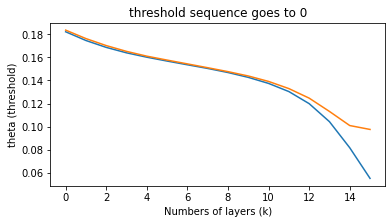

In [ ]:
fig = plt.figure(1, figsize=(6,3))
plt.plot(np.arange(Listacp_model.depth), thetas.detach().cpu().numpy())
plt.plot(np.arange(Listacp_model_noisy.depth), thetas_noisy.detach().cpu().numpy())
plt.title('threshold sequence goes to 0')
plt.xlabel('Numbers of layers (k)')
plt.ylabel('theta (threshold)')


#### **Validation du theorème 2:**

In [ ]:
# NMSE de chaque modele:

#LISTA:
partials_NMSE = Lista_model.__partial_NMSE__(train_data[:][0], train_data[:][1])
partials_NMSE_Lista = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]

partials_NMSE = Lista_model_noisy.__partial_NMSE__(train_data_noisy[:][0], train_data_noisy[:][1])
partials_NMSE_Lista_noisy = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]

#LISTA-CP:
partials_NMSE = Listacp_model.__partial_NMSE__(train_data[:][0], train_data[:][1])
partials_NMSE_Listacp = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]

partials_NMSE = Listacp_model_noisy.__partial_NMSE__(train_data_noisy[:][0], train_data_noisy[:][1])
partials_NMSE_Listacp_noisy = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]

# ISTA:
partials_NMSE = fb_model.__partial_NMSE__(train_data[:][0], train_data[:][1])
partials_NMSE_fb = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]

partials_NMSE = fb_model.__partial_NMSE__(train_data_noisy[:][0], train_data_noisy[:][1])
partials_NMSE_fb_noisy = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]

# FISTA:
partials_NMSE = ffb_model.__partial_NMSE__(train_data[:][0], train_data[:][1])
partials_NMSE_ffb = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]

partials_NMSE = ffb_model.__partial_NMSE__(train_data_noisy[:][0], train_data_noisy[:][1])
partials_NMSE_ffb_noisy = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]

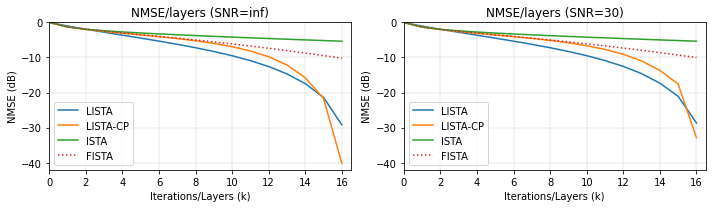

In [ ]:
#Plot des NMSE
fig = plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(np.arange(Listacp_model.depth+1), partials_NMSE_Lista, label = 'LISTA' )
plt.plot(np.arange(Listacp_model.depth+1), partials_NMSE_Listacp, label = 'LISTA-CP' )
plt.plot(np.arange(fb_model.Niter+1), partials_NMSE_fb, label = 'ISTA' )
plt.plot(np.arange(fb_model.Niter+1), partials_NMSE_ffb, label = 'FISTA', linestyle = 'dotted' )
plt.title('NMSE/layers (SNR=inf)')
plt.xlabel('Iterations/Layers (k)')
plt.ylabel('NMSE (dB)')
plt.grid(color='grey', linestyle='--', linewidth=0.25)
plt.axis([0,16.5,-42,0])
plt.legend()

plt.subplot(122)
plt.plot(np.arange(Listacp_model_noisy.depth+1), partials_NMSE_Lista_noisy, label = 'LISTA' )
plt.plot(np.arange(Listacp_model_noisy.depth+1), partials_NMSE_Listacp_noisy, label = 'LISTA-CP' )
plt.plot(np.arange(fb_model.Niter+1), partials_NMSE_fb_noisy, label = 'ISTA' )
plt.plot(np.arange(fb_model.Niter+1), partials_NMSE_ffb_noisy, label = 'FISTA', linestyle = 'dotted' )
plt.title('NMSE/layers (SNR=30)')
plt.xlabel('Iterations/Layers (k)')
plt.ylabel('NMSE (dB)')
plt.grid(color='grey', linestyle='--', linewidth=0.25)
plt.axis([0,16.5,-42,0])
plt.legend()
plt.tight_layout()

#### **Validation discussion théoreme 2:**


In [ ]:
# ISTA lambd = 0.1:
fb_model1 = Forward_Backward( size_observed=size_observed, size_target=size_target, lambd=0.1, Niter=800, A=A)


# ISTA lambd = 0.05:
fb_model2 = Forward_Backward( size_observed=size_observed, size_target=size_target, lambd=0.05, Niter=800, A=A)

# ISTA lambd = 0.025:
fb_model3 = Forward_Backward( size_observed=size_observed, size_target=size_target, lambd=0.025, Niter=800, A=A)

# ISTA adaptative:
fb_model_adaptative = Forward_Backward_adaptative(size_observed=size_observed, size_target=size_target, lambd=0.1, Niter=800, A=A)



In [ ]:
# NMSE de chaque modele:

# ISTA adaptative:
partials_NMSE = fb_model_adaptative.__partial_NMSE__(train_data[:][0], train_data[:][1])
partials_NMSE_fb_adapt = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]

# ISTA 1:
partials_NMSE = fb_model1.__partial_NMSE__(train_data[:][0], train_data[:][1])
partials_NMSE_fb1 = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]

# ISTA 2:
partials_NMSE = fb_model2.__partial_NMSE__(train_data[:][0], train_data[:][1])
partials_NMSE_fb2 = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]

# ISTA 3:
partials_NMSE = fb_model3.__partial_NMSE__(train_data[:][0], train_data[:][1])
partials_NMSE_fb3 = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]

#LISTA-CP:
partials_NMSE = Listacp_model.__partial_NMSE__(train_data[:][0], train_data[:][1])
partials_NMSE_Listacp = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]


torch.Size([1000]) torch.Size([1000, 500])


RuntimeError: ignored

In [ ]:
#Plot des NMSE

fig = plt.figure(1, figsize=(9,4))
plt.plot(np.arange(fb_model1.Niter+1), partials_NMSE_fb1, label = 'ISTA lambd = 0.1' )
plt.plot(np.arange(fb_model2.Niter+1), partials_NMSE_fb2, label = 'ISTA lambd = 0.05' )
plt.plot(np.arange(fb_model3.Niter+1), partials_NMSE_fb3, label = 'ISTA lambd = 0.025' )
plt.plot(np.arange(fb_model_adaptative.Niter+1), partials_NMSE_fb_adapt, label = 'ISTA adaptative' )
plt.plot(np.arange(Listacp_model.depth+1), partials_NMSE_Listacp, label = 'LISTA-CP' )
plt.title('NMSE/layers (SNR=inf)')
plt.xlabel('Iterations/Layers (k)')
plt.ylabel('NMSE (dB)')
plt.legend()

NameError: ignored

<Figure size 648x288 with 0 Axes>

# **Implémentation de LISTA-SS:**

#### **Définition du modèle:**

In [ ]:
# Voir models LISTA, setup_layers

class LISTASS_model(torch.nn.Module):
  def __init__(self, size_observed, size_target, A, percent=1., max_percent=5, depth=16, init = True):
    super().__init__()
    from torch.nn import ModuleList, Flatten, Linear, ReLU, parameter
    # Quelques attributs:
    self.A = A
    gram_A, L = max_eig(self.A)
    self.gram_A = gram_A
    self.L = L * 1.001

    self.depth = depth
    self.size_observed = size_observed
    self.size_target = size_target

    self.p = percent
    self.max_p = max_percent

    self.ps = [(t+1) * self.p for t in range (self.depth)]
    self.ps = torch.clamp(torch.tensor(self.ps), 0.0, self.max_p).to(device)

    #rates of Thresholds:
    if init:
      self.threshold = parameter.Parameter(torch.ones([self.depth], dtype=torch.float32).to(device)/self.L).to(device)
      #self.param_group = [{"params": self.threshold, "l1_proj": lambda x: x.clamp(min=0)}]
    else:
      self.threshold = parameter.Parameter(torch.randn(self.depth)).to(device)
      #self.param_groups = [{"params": self.threshold, "l1_proj": lambda x: x.clamp(min=0)}]

    #Weights and Biases:
    self.bias_layers = ModuleList()
    self.weight_layers = ModuleList()

    for i in range(depth):
      # Init weight_layers & bias_layers
      weight_layer = Linear(size_target, size_target, bias=False)
      bias_layer = Linear(size_observed, size_target, bias=False)

      if init:
        weight_layer.weight = nn.Parameter(torch.eye(self.size_target).to(device) - self.gram_A/self.L)
        bias_layer.weight = nn.Parameter(self.A.transpose(0,1)/self.L)


      self.weight_layers.append(weight_layer.to(device))
      self.bias_layers.append(bias_layer.to(device))

  def __shrink__(self, x, threshold):
        #return torch.sign(x) * torch.max(torch.abs(x) - torch.max(threshold, torch.tensor([0.]).to(device)), torch.zeros_like(x))
        return torch.sign(x) * (torch.abs(x) - threshold).clamp(min=0.)


  def __shrinkss__(self, x, threshold, p):
    with torch.no_grad():
      abs_x = torch.abs(x).to(device)
      thresh_index = torch.ceil((100 - p) / 100 * x.shape[1]).to(device)
      sorted_rows, _ = torch.sort(abs_x)
      thresh = sorted_rows[:, int(thresh_index)-1].to(device)
      index_ = (abs_x >= threshold) & (abs_x >= thresh[:, None])
      index_ = index_.float().detach()
      cindex_ = 1.0 - index_
    return (index_ * x + self.__shrink__(cindex_ * x, threshold))

    # abs_ = torch.abs(x).to(device)
    # thresh = torch.zeros(x.shape[0]).to(device)
    # with torch.no_grad():
    #   thresh_index = torch.ceil((100 - p) / 100 * x.shape[1]).to(device)
    #   for i in range(x.shape[0]):
    #       sorted_row, _ = torch.sort(x[i])
    #       thresh[int(i)] = sorted_row[(thresh_index.to(torch.long)).to(device)].to(device)

    #   index_ = (abs_ > threshold) & (abs_ > thresh[:,None])
    #   index_ = index_.float()
    #   index_ = index_.detach()
    #   cindex_ = 1.0 - index_  # complementary index
    # # Il faut enlever index_ et cindex_ dans le return
    # # return (index_ * x +
    # #         self.__shrink__(cindex_ * x, threshold), index_, cindex_)
    # return (index_ * x +
    #         self.__shrink__(cindex_ * x, threshold))

  def forward(self, x):

    u = torch.zeros((x.shape[0], size_target)).to(device)

    for  weight, bias, i in  zip(self.weight_layers, self.bias_layers, range(self.depth)):
            u = self.__shrinkss__(weight(u) + bias(x), self.threshold[i], self.ps[i])
    return u

  def __partial_forward__(self, x):
    u = torch.zeros((x.shape[0], size_target)).to(device)
    partials_u = [u]
    for  weight, bias, i in  zip(self.weight_layers, self.bias_layers, range(self.depth)):
            u = self.__shrinkss__(weight(u) + bias(x), self.threshold[i], self.ps[i])
            partials_u.append(u)
    return partials_u

  def __partial_NMSE__(self, x, y):
    partials_u = self.__partial_forward__(x)
    partials_NMSE = []
    for partial_u in partials_u:
      partial_error = partial_u - y
      norm_error = torch.norm(partial_error, p = 2, dim = 1)**2
      norm_x = torch.norm(x, p=2, dim = 1)**2
      partials_NMSE.append(10*torch.log10(torch.mean(norm_error)/torch.mean(norm_x)))
    return(partials_NMSE)




In [ ]:
test_SS  = LISTASS_model( size_observed=size_observed, size_target=size_target, A=A, depth=16, init=True)
tensor = torch.tensor([[1,-10,3,11,8,9,10,11, 7,1,1], [-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11],[-5,-4,-3,-2,-1,0,1,2,3,4,5]], device = device)
thresholdd = 2.5
percent = torch.tensor([25]).to(device)
test_SS.__shrinkss__(tensor, thresholdd, percent)

tensor([[  0.0000, -10.0000,   0.5000,  11.0000,   5.5000,   6.5000,  10.0000,
          11.0000,   4.5000,   0.0000,   0.0000],
        [ -0.0000,  -0.0000,  -0.5000,  -1.5000,  -2.5000,  -3.5000,  -4.5000,
          -5.5000,  -9.0000, -10.0000, -11.0000],
        [ -5.0000,  -4.0000,  -0.5000,  -0.0000,  -0.0000,   0.0000,   0.0000,
           0.0000,   0.5000,   4.0000,   5.0000]], device='cuda:0')

#### **Entrainement:**

In [ ]:
#nb_samples = train_data[:][0].shape[0]
nb_samples = len(train_data)
size_target = train_data[:][1].shape[1]
size_observed = train_data[:][0].shape[1]

# Create the neural network and move it to the computational device
Listass_model = LISTASS_model( size_observed=size_observed, size_target=size_target, A=A, depth=16, init=True).to(device)
Listass_model_noisy = LISTASS_model( size_observed=size_observed, size_target=size_target, A=A, depth=16, init=True).to(device)

print("Number of parameters:", sum(w.numel() for w in Listass_model.parameters()))
print(Listass_model.ps)
# Create the DataLoader and configure mini-batching
batch_size = nb_samples
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_dataloader_noisy = DataLoader(train_data_noisy, batch_size=batch_size, shuffle=True)
val_dataloader_noisy = DataLoader(test_data_noisy, batch_size=batch_size, shuffle=True)

# Initialize loss, optimizer and trainer
loss = MSELoss()
optimizer = Adam(Listass_model.parameters(), lr=1.e-3)
#optimizer = Adadelta(Listass_model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0, foreach=None, maximize=False)
optimizer_noisy = Adam(Listass_model_noisy.parameters(), lr=1.e-3)
#optimizer_noisy = Adadelta(Listass_model_noisy.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0, foreach=None, maximize=False)

scheduler = False
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)
Listass_trainer = Trainer(Listass_model, optimizer, scheduler, loss,
                  train_dataloader, val_dataloader, check_val_every_n_epoch=100)
Listass_trainer_noisy = Trainer(Listass_model_noisy, optimizer_noisy, scheduler, loss,
                  train_dataloader_noisy, val_dataloader_noisy, check_val_every_n_epoch=100)
# Run training
print(Listass_model.threshold)
Listass_trainer.run(5000)
print(Listass_model.threshold)

print(Listass_model_noisy.threshold)
Listass_trainer_noisy.run(5000)
print(Listass_model_noisy.threshold)

Number of parameters: 6000016
tensor([1., 2., 3., 4., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.],
       device='cuda:0')
Parameter containing:
tensor([0.1802, 0.1802, 0.1802, 0.1802, 0.1802, 0.1802, 0.1802, 0.1802, 0.1802,
        0.1802, 0.1802, 0.1802, 0.1802, 0.1802, 0.1802, 0.1802],
       device='cuda:0', requires_grad=True)


Training:   0%|          | 0/5000 [00:00<?, ?epoch/s]

Validation epoch  100 | Loss: 2.42e-02 | PSNR: 1.65e+01 | Wall time: 2.80e-02
Validation epoch  200 | Loss: 2.34e-02 | PSNR: 1.67e+01 | Wall time: 2.64e-02
Validation epoch  300 | Loss: 2.34e-02 | PSNR: 1.67e+01 | Wall time: 2.81e-02
Validation epoch  400 | Loss: 2.34e-02 | PSNR: 1.67e+01 | Wall time: 2.83e-02
Validation epoch  500 | Loss: 2.34e-02 | PSNR: 1.67e+01 | Wall time: 2.53e-02
Validation epoch  600 | Loss: 2.34e-02 | PSNR: 1.67e+01 | Wall time: 2.62e-02
Validation epoch  700 | Loss: 2.35e-02 | PSNR: 1.67e+01 | Wall time: 2.64e-02
Validation epoch  800 | Loss: 2.36e-02 | PSNR: 1.66e+01 | Wall time: 2.65e-02
Validation epoch  900 | Loss: 2.36e-02 | PSNR: 1.66e+01 | Wall time: 2.67e-02
Validation epoch 1000 | Loss: 2.39e-02 | PSNR: 1.66e+01 | Wall time: 2.76e-02
Validation epoch 1100 | Loss: 2.40e-02 | PSNR: 1.66e+01 | Wall time: 2.55e-02
Validation epoch 1200 | Loss: 2.40e-02 | PSNR: 1.65e+01 | Wall time: 2.64e-02
Validation epoch 1300 | Loss: 2.41e-02 | PSNR: 1.65e+01 | Wall t

Training:   0%|          | 0/5000 [00:00<?, ?epoch/s]

Validation epoch  100 | Loss: 2.42e-02 | PSNR: 1.65e+01 | Wall time: 2.70e-02
Validation epoch  200 | Loss: 2.34e-02 | PSNR: 1.67e+01 | Wall time: 3.08e-02
Validation epoch  300 | Loss: 2.31e-02 | PSNR: 1.67e+01 | Wall time: 2.78e-02
Validation epoch  400 | Loss: 2.30e-02 | PSNR: 1.67e+01 | Wall time: 3.07e-02
Validation epoch  500 | Loss: 2.32e-02 | PSNR: 1.67e+01 | Wall time: 2.78e-02
Validation epoch  600 | Loss: 2.34e-02 | PSNR: 1.67e+01 | Wall time: 2.75e-02
Validation epoch  700 | Loss: 2.33e-02 | PSNR: 1.67e+01 | Wall time: 2.70e-02
Validation epoch  800 | Loss: 2.36e-02 | PSNR: 1.66e+01 | Wall time: 2.82e-02
Validation epoch  900 | Loss: 2.37e-02 | PSNR: 1.66e+01 | Wall time: 2.92e-02
Validation epoch 1000 | Loss: 2.37e-02 | PSNR: 1.66e+01 | Wall time: 2.88e-02
Validation epoch 1100 | Loss: 2.38e-02 | PSNR: 1.66e+01 | Wall time: 2.89e-02
Validation epoch 1200 | Loss: 2.39e-02 | PSNR: 1.66e+01 | Wall time: 2.83e-02
Validation epoch 1300 | Loss: 2.41e-02 | PSNR: 1.65e+01 | Wall t

In [ ]:
# sauvegarder les modèles
torch.save(Listass_model.state_dict(), '/content/drive/MyDrive/Data/LISTA/Listass_model.pth')
torch.save(Listass_model_noisy.state_dict(), '/content/drive/MyDrive/Data/LISTA/Listass_model_noisy.pth')


In [ ]:
# charger les modèles
Listass_model = LISTASS_model(size_observed=size_observed, size_target=size_target, A=A, depth=16, init=True).to(device)
Listass_model.load_state_dict(torch.load('/content/drive/MyDrive/Data/LISTA/Listass_model.pth'))
Listass_model_noisy = LISTASS_model(size_observed=size_observed, size_target=size_target, A=A, depth=16, init=True).to(device)
Listass_model_noisy.load_state_dict(torch.load('/content/drive/MyDrive/Data/LISTA/Listass_model_noisy.pth'))


<All keys matched successfully>

#### **Valeurs de theta et norme couplage:**

In [ ]:
with torch.no_grad():
    list_parameters = list(Listass_model.parameters())
    thetas = Listass_model.threshold
    list_weights = [ Listass_model.weight_layers[i].weight - torch.eye(Listass_model.size_target).to(device) + torch.matmul(Listass_model.bias_layers[i].weight, A) for i in range(Listass_model.depth)]
    list_weights_norm = [torch.linalg.norm(list_weights[i], dim=(0,1), ord=2).detach().item() for i in range(len(list_weights))]

Text(0, 0.5, 'norm of weight-(I-bias*A)')

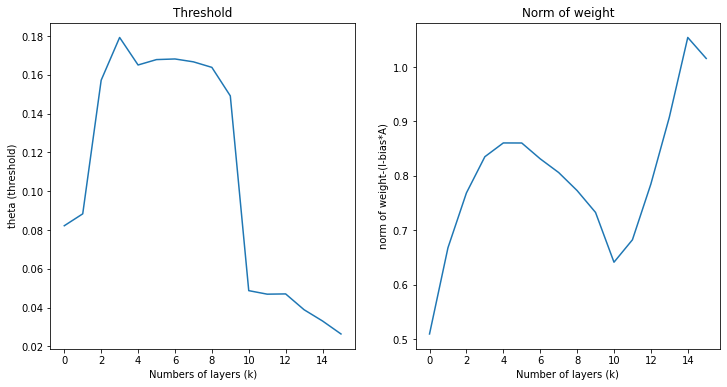

In [ ]:

fig = plt.figure(1, figsize=(12,6))
plt.subplot(121)
plt.plot(np.arange(Listass_model.depth), thetas.detach().cpu().numpy())
plt.title('Threshold')
plt.xlabel('Numbers of layers (k)')
plt.ylabel('theta (threshold)')

plt.subplot(122)
plt.plot(np.arange(Listass_model.depth), np.array(list_weights_norm))
plt.title('Norm of weight')
plt.xlabel('Number of layers (k)')
plt.ylabel('norm of weight-(I-bias*A)')

# **Implémentation de LISTA-CPSS:**

#### **Définition du modèle:**

In [ ]:
class LISTACPSS_model(torch.nn.Module):
  def __init__(self, size_observed, size_target, A, percent=1.2, max_percent=5, depth=16, init = True):
    super().__init__()
    from torch.nn import ModuleList, Flatten, Linear, ReLU, parameter
    # Quelques attributs:
    self.A = A
    gram_A, L = max_eig(self.A)
    self.gram_A = gram_A
    self.L = L * 1.001

    self.depth = depth
    self.size_observed = size_observed
    self.size_target = size_target

    self.p = percent
    self.max_p = max_percent

    self.ps = [(t+1) * self.p for t in range (self.depth)]
    self.ps = torch.clip (torch.tensor(self.ps), 0.0, self.max_p)

    #rates of Thresholds:
    if init:
      self.threshold = parameter.Parameter(torch.ones([self.depth], dtype=torch.float32).to(device)/self.L).to(device)
      #self.param_group = [{"params": self.threshold, "l1_proj": lambda x: x.clamp(min=0)}]
    else:
      self.threshold = parameter.Parameter(torch.randn(self.depth))
      #self.param_groups = [{"params": self.threshold, "l1_proj": lambda x: x.clamp(min=0)}]

    #Weights and Biases:
    self.bias_layers = ModuleList()
    for i in range(depth):
      # Init weight_layers & bias_layers
      bias_layer = Linear(size_observed, size_target, bias=False)

      if init:
        bias_layer.weight = nn.Parameter(self.A.transpose(0,1)/self.L)

      self.bias_layers.append(bias_layer.to(device))

  def __shrink__(self, x, threshold):
        #return torch.sign(x) * torch.max(torch.abs(x) - torch.max(threshold, torch.tensor([0.]).to(device)), torch.zeros_like(x))
        return torch.sign(x) * (torch.abs(x) - threshold).clamp(min=0.)

  def __shrinkss__(self, x, threshold, p):

      with torch.no_grad():
        abs_x = torch.abs(x).to(device)
        thresh_index = torch.ceil((100 - p) / 100 * x.shape[1]).to(device)
        sorted_rows, _ = torch.sort(abs_x)
        thresh = sorted_rows[:, int(thresh_index)-1].to(device)
        index_ = (abs_x >= threshold) & (abs_x >= thresh[:, None])
        index_ = index_.float().detach()
        cindex_ = 1.0 - index_
      return (index_ * x + self.__shrink__(cindex_ * x, threshold))


      # abs_x = torch.abs(x).to(device)
      # with torch.no_grad():
      #   thresh_index = torch.ceil((100 - p) / 100 * x.shape[1]).to(device)
      #   sorted_rows, _ = torch.sort(x)
      #   thresh = sorted_rows[:, int(thresh_index)].to(device)
      #   index_ = (abs_x > threshold) & (abs_x > thresh[:, None])
      #   index_ = index_.float().detach()
      #   cindex_ = 1.0 - index_
      # return (index_ * x + self.__shrink__(cindex_ * x, threshold))

    # abs_ = torch.abs(x).to(device)
    # thresh = torch.zeros(x.shape[0]).to(device)
    # with torch.no_grad():
    #   thresh_index = torch.ceil((100 - p) / 100 * x.shape[1]).to(device)
    #   for i in range(x.shape[0]):
    #       sorted_row, _ = torch.sort(x[i])
    #       thresh[int(i)] = sorted_row[(thresh_index.to(torch.long)).to(device)].to(device)
    #   index_ = (abs_ > threshold) & (abs_ > thresh[:,None])
    #   index_ = index_.float()
    #   """Stop gradient at index_, considering it as constant."""
    #   index_ = index_.detach()
    #   cindex_ = 1.0 - index_  # complementary index

    # return (index_ * x +
    #         self.__shrink__(cindex_ * x, threshold))

  def forward(self, x):
    u = torch.zeros((x.shape[0], size_target)).to(device)

    for  bias, i in  zip(self.bias_layers, range(self.depth)):
            u = self.__shrinkss__(u + bias(x - torch.matmul(u, self.A.transpose(0,1))), self.threshold[i], self.ps[i])
    return(u)

  def __partial_forward__(self, x):
    u = torch.zeros((x.shape[0], size_target)).to(device)
    partials_u = [u]
    for  bias, i in  zip(self.bias_layers, range(self.depth)):
            u = self.__shrinkss__(u + bias(x - torch.matmul(u, self.A.transpose(0,1))), self.threshold[i], self.ps[i])
            partials_u.append(u)
    return partials_u

  def __partial_NMSE__(self, x, y):
    partials_u = self.__partial_forward__(x)
    partials_NMSE = []
    for partial_u in partials_u:
      partial_error = partial_u - y
      norm_error = torch.norm(partial_error, p = 2, dim = 1)**2
      norm_x = torch.norm(x, p=2, dim = 1)**2
      partials_NMSE.append(10*torch.log10(torch.mean(norm_error)/torch.mean(norm_x)))
    return(partials_NMSE)


#### **Entrianement:**

In [ ]:
#nb_samples = train_data[:][0].shape[0]
nb_samples = len(train_data)
size_target = train_data[:][1].shape[1]
size_observed = train_data[:][0].shape[1]

# Create the neural network and move it to the computational device
Listacpss_model = LISTACPSS_model( size_observed=size_observed, size_target=size_target, A=A, depth=16, init=True).to(device)
print("Number of parameters:", sum(w.numel() for w in Listacpss_model.parameters()))
print(Listacpss_model.ps)
# Create the DataLoader and configure mini-batching
batch_size = nb_samples
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Initialize loss, optimizer and trainer
loss = MSELoss()
optimizer = Adam(Listacpss_model.parameters(), lr=1e-3)
scheduler = False
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)
Listacpss_trainer = Trainer(Listacpss_model, optimizer, scheduler, loss,
                  train_dataloader, val_dataloader, check_val_every_n_epoch=100)

# Run training
print(Listacpss_model.threshold)
Listacpss_trainer.run(5000)
print(Listacpss_model.threshold)


Number of parameters: 2000016
tensor([1.2000, 2.4000, 3.6000, 4.8000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000,
        5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000])
Parameter containing:
tensor([0.1732, 0.1732, 0.1732, 0.1732, 0.1732, 0.1732, 0.1732, 0.1732, 0.1732,
        0.1732, 0.1732, 0.1732, 0.1732, 0.1732, 0.1732, 0.1732],
       device='cuda:0', requires_grad=True)


Training:   0%|          | 0/5000 [00:00<?, ?epoch/s]

Validation epoch  100 | Loss: 5.63e-03 | PSNR: 2.40e+01 | Wall time: 2.78e-02
Validation epoch  200 | Loss: 6.05e-03 | PSNR: 2.39e+01 | Wall time: 2.83e-02
Validation epoch  300 | Loss: 6.56e-03 | PSNR: 2.35e+01 | Wall time: 3.73e-02
Validation epoch  400 | Loss: 7.03e-03 | PSNR: 2.31e+01 | Wall time: 2.85e-02
Validation epoch  500 | Loss: 7.40e-03 | PSNR: 2.29e+01 | Wall time: 2.85e-02
Validation epoch  600 | Loss: 7.75e-03 | PSNR: 2.26e+01 | Wall time: 2.70e-02
Validation epoch  700 | Loss: 8.07e-03 | PSNR: 2.24e+01 | Wall time: 2.64e-02
Validation epoch  800 | Loss: 8.34e-03 | PSNR: 2.22e+01 | Wall time: 2.70e-02
Validation epoch  900 | Loss: 8.58e-03 | PSNR: 2.21e+01 | Wall time: 3.12e-02
Validation epoch 1000 | Loss: 8.79e-03 | PSNR: 2.19e+01 | Wall time: 2.74e-02
Validation epoch 1100 | Loss: 8.96e-03 | PSNR: 2.18e+01 | Wall time: 2.79e-02
Validation epoch 1200 | Loss: 9.13e-03 | PSNR: 2.17e+01 | Wall time: 2.70e-02
Validation epoch 1300 | Loss: 9.30e-03 | PSNR: 2.16e+01 | Wall t

#### **Entrianement:**

In [ ]:
#nb_samples = train_data[:][0].shape[0]
nb_samples = len(train_data)
size_target = train_data[:][1].shape[1]
size_observed = train_data[:][0].shape[1]

# Create the neural network and move it to the computational device
Listacpss_model = LISTACPSS_model( size_observed=size_observed, size_target=size_target, A=A, depth=16, init=True).to(device)
Listacpss_model_noisy = LISTACPSS_model( size_observed=size_observed, size_target=size_target, A=A, depth=16, init=True).to(device)

print("Number of parameters:", sum(w.numel() for w in Listacpss_model.parameters()))
print(Listacpss_model.ps)
# Create the DataLoader and configure mini-batching
batch_size = nb_samples
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_dataloader_noisy = DataLoader(train_data_noisy, batch_size=batch_size, shuffle=True)
val_dataloader_noisy = DataLoader(test_data_noisy, batch_size=batch_size, shuffle=True)

# Initialize loss, optimizer and trainer
loss = MSELoss()
optimizer = Adam(Listacpss_model.parameters(), lr=1e-3)
optimizer_noisy = Adam(Listacpss_model_noisy.parameters(), lr=1e-3)
scheduler = False
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)
Listacpss_trainer = Trainer(Listacpss_model, optimizer, scheduler, loss,
                  train_dataloader, val_dataloader, check_val_every_n_epoch=100)
Listacpss_trainer_noisy = Trainer(Listacpss_model_noisy, optimizer_noisy, scheduler, loss,
                  train_dataloader_noisy, val_dataloader_noisy, check_val_every_n_epoch=100)

# Run training
print(Listacpss_model.threshold)
Listacpss_trainer.run(5000)
print(Listacpss_model.threshold)

# Run training
print(Listacpss_model_noisy.threshold)
Listacpss_trainer_noisy.run(5000)
print(Listacpss_model_noisy.threshold)


Number of parameters: 2000016
tensor([1.2000, 2.4000, 3.6000, 4.8000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000,
        5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000])
Parameter containing:
tensor([0.1802, 0.1802, 0.1802, 0.1802, 0.1802, 0.1802, 0.1802, 0.1802, 0.1802,
        0.1802, 0.1802, 0.1802, 0.1802, 0.1802, 0.1802, 0.1802],
       device='cuda:0', requires_grad=True)


Training:   0%|          | 0/5000 [00:00<?, ?epoch/s]

Validation epoch  100 | Loss: 5.73e-03 | PSNR: 2.39e+01 | Wall time: 2.83e-02
Validation epoch  200 | Loss: 6.03e-03 | PSNR: 2.39e+01 | Wall time: 2.77e-02
Validation epoch  300 | Loss: 6.53e-03 | PSNR: 2.36e+01 | Wall time: 2.97e-02
Validation epoch  400 | Loss: 6.93e-03 | PSNR: 2.33e+01 | Wall time: 2.84e-02
Validation epoch  500 | Loss: 7.31e-03 | PSNR: 2.30e+01 | Wall time: 2.79e-02
Validation epoch  600 | Loss: 7.65e-03 | PSNR: 2.28e+01 | Wall time: 2.87e-02
Validation epoch  700 | Loss: 7.95e-03 | PSNR: 2.25e+01 | Wall time: 2.87e-02
Validation epoch  800 | Loss: 8.24e-03 | PSNR: 2.23e+01 | Wall time: 2.85e-02
Validation epoch  900 | Loss: 8.49e-03 | PSNR: 2.22e+01 | Wall time: 3.52e-02
Validation epoch 1000 | Loss: 8.65e-03 | PSNR: 2.20e+01 | Wall time: 3.00e-02
Validation epoch 1100 | Loss: 8.85e-03 | PSNR: 2.19e+01 | Wall time: 2.85e-02
Validation epoch 1200 | Loss: 9.02e-03 | PSNR: 2.18e+01 | Wall time: 3.19e-02
Validation epoch 1300 | Loss: 9.17e-03 | PSNR: 2.17e+01 | Wall t

Training:   0%|          | 0/5000 [00:00<?, ?epoch/s]

Validation epoch  100 | Loss: 6.21e-03 | PSNR: 2.34e+01 | Wall time: 2.73e-02
Validation epoch  200 | Loss: 6.43e-03 | PSNR: 2.33e+01 | Wall time: 3.13e-02
Validation epoch  300 | Loss: 6.78e-03 | PSNR: 2.31e+01 | Wall time: 2.70e-02
Validation epoch  400 | Loss: 7.02e-03 | PSNR: 2.29e+01 | Wall time: 2.76e-02
Validation epoch  500 | Loss: 7.19e-03 | PSNR: 2.28e+01 | Wall time: 3.02e-02
Validation epoch  600 | Loss: 7.35e-03 | PSNR: 2.26e+01 | Wall time: 2.88e-02
Validation epoch  700 | Loss: 7.46e-03 | PSNR: 2.26e+01 | Wall time: 2.97e-02
Validation epoch  800 | Loss: 7.54e-03 | PSNR: 2.25e+01 | Wall time: 2.81e-02
Validation epoch  900 | Loss: 7.60e-03 | PSNR: 2.25e+01 | Wall time: 2.81e-02
Validation epoch 1000 | Loss: 7.63e-03 | PSNR: 2.24e+01 | Wall time: 3.01e-02
Validation epoch 1100 | Loss: 7.67e-03 | PSNR: 2.24e+01 | Wall time: 2.79e-02
Validation epoch 1200 | Loss: 7.72e-03 | PSNR: 2.24e+01 | Wall time: 2.81e-02
Validation epoch 1300 | Loss: 7.75e-03 | PSNR: 2.23e+01 | Wall t

#### **Valeurs de theta:**

Text(0, 0.5, 'theta (threshold)')

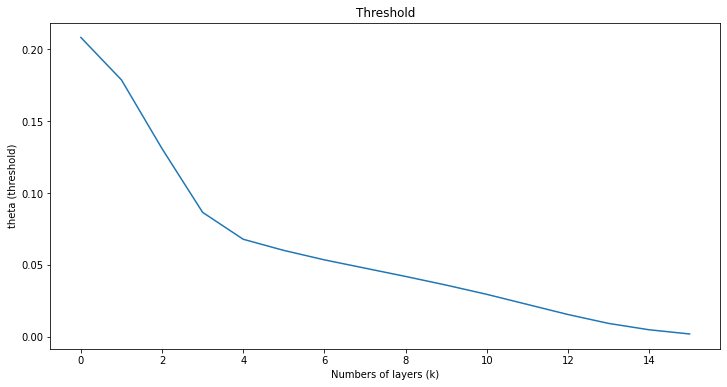

In [ ]:
fig = plt.figure(1, figsize=(12,6))
with torch.no_grad():
    list_parameters = list(Listacpss_model.parameters())
    thetas = Listacpss_model.threshold
plt.plot(np.arange(Listacpss_model.depth), thetas.detach().cpu().numpy())
plt.title('Threshold')
plt.xlabel('Numbers of layers (k)')
plt.ylabel('theta (threshold)')


In [ ]:
print(Listacpss_model_noisy.threshold)
Listacpss_trainer_noisy.run(10000)
print(Listacpss_model_noisy.threshold)

Parameter containing:
tensor([0.1866, 0.1513, 0.1091, 0.0703, 0.0553, 0.0515, 0.0492, 0.0462, 0.0433,
        0.0406, 0.0383, 0.0368, 0.0357, 0.0347, 0.0347, 0.0433],
       device='cuda:0', requires_grad=True)


Training:  50%|#####     | 5000/10000 [00:00<?, ?epoch/s]

Validation epoch 5100 | Loss: 8.02e-03 | PSNR: 2.21e+01 | Wall time: 2.94e-02
Validation epoch 5200 | Loss: 8.03e-03 | PSNR: 2.21e+01 | Wall time: 3.01e-02
Validation epoch 5300 | Loss: 8.05e-03 | PSNR: 2.21e+01 | Wall time: 3.17e-02
Validation epoch 5400 | Loss: 8.06e-03 | PSNR: 2.21e+01 | Wall time: 2.72e-02
Validation epoch 5500 | Loss: 8.05e-03 | PSNR: 2.21e+01 | Wall time: 2.70e-02
Validation epoch 5600 | Loss: 8.06e-03 | PSNR: 2.21e+01 | Wall time: 2.64e-02
Validation epoch 5700 | Loss: 8.05e-03 | PSNR: 2.21e+01 | Wall time: 2.81e-02
Validation epoch 5800 | Loss: 8.05e-03 | PSNR: 2.21e+01 | Wall time: 2.71e-02
Validation epoch 5900 | Loss: 8.05e-03 | PSNR: 2.21e+01 | Wall time: 2.93e-02
Validation epoch 6000 | Loss: 8.06e-03 | PSNR: 2.21e+01 | Wall time: 2.77e-02
Parameter containing:
tensor([0.1858, 0.1479, 0.1074, 0.0692, 0.0547, 0.0510, 0.0489, 0.0459, 0.0428,
        0.0399, 0.0378, 0.0362, 0.0350, 0.0337, 0.0329, 0.0401],
       device='cuda:0', requires_grad=True)


#### **Validation du théoreme 3:**

In [ ]:
# NMSE de chaque modele:

#LISTA:
partials_NMSE = Lista_model.__partial_NMSE__(train_data[:][0], train_data[:][1])
partials_NMSE_Lista = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]

#LISTA-CP:
partials_NMSE = Listacp_model.__partial_NMSE__(train_data[:][0], train_data[:][1])
partials_NMSE_Listacp = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]

# ISTA:
partials_NMSE = fb_model.__partial_NMSE__(train_data[:][0], train_data[:][1])
partials_NMSE_fb = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]

# FISTA:
partials_NMSE = ffb_model.__partial_NMSE__(train_data[:][0], train_data[:][1])
partials_NMSE_ffb = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]

#LISTA-SS:
partials_NMSE = Listass_model.__partial_NMSE__(train_data[:][0], train_data[:][1])
partials_NMSE_Listass = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]

#LISTA-CPSS:
partials_NMSE = Listacpss_model.__partial_NMSE__(train_data[:][0], train_data[:][1])
partials_NMSE_Listacpss = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]

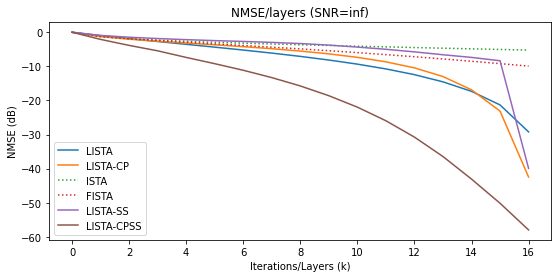

In [ ]:
#Plot des NMSE

fig = plt.figure(1, figsize=(9,4))
plt.plot(np.arange(Listacp_model.depth+1), partials_NMSE_Lista, label = 'LISTA' )
plt.plot(np.arange(Listacp_model.depth+1), partials_NMSE_Listacp, label = 'LISTA-CP' )
plt.plot(np.arange(fb_model.Niter+1), partials_NMSE_fb, label = 'ISTA', linestyle = 'dotted' )
plt.plot(np.arange(fb_model.Niter+1), partials_NMSE_ffb, label = 'FISTA', linestyle = 'dotted' )
plt.plot(np.arange(Listacp_model.depth+1), partials_NMSE_Listass, label = 'LISTA-SS' )
plt.plot(np.arange(Listacp_model.depth+1), partials_NMSE_Listacpss, label = 'LISTA-CPSS' )
plt.title('NMSE/layers (SNR=inf)')
plt.xlabel('Iterations/Layers (k)')
plt.ylabel('NMSE (dB)')
plt.legend()


In [ ]:
#LISTA:
partials_NMSE = Lista_model.__partial_NMSE__(train_data[:][0], train_data[:][1])
partials_NMSE_Lista = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]

partials_NMSE = Lista_model_noisy.__partial_NMSE__(train_data_noisy[:][0], train_data_noisy[:][1])
partials_NMSE_Lista_noisy = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]

#LISTA-CP:
partials_NMSE = Listacp_model.__partial_NMSE__(train_data[:][0], train_data[:][1])
partials_NMSE_Listacp = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]

partials_NMSE = Listacp_model_noisy.__partial_NMSE__(train_data_noisy[:][0], train_data_noisy[:][1])
partials_NMSE_Listacp_noisy = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]

#LISTA-SS:
partials_NMSE = Listass_model.__partial_NMSE__(train_data[:][0], train_data[:][1])
partials_NMSE_Listass = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]

partials_NMSE = Listass_model_noisy.__partial_NMSE__(train_data_noisy[:][0], train_data_noisy[:][1])
partials_NMSE_Listass_noisy = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]

#LISTA-CPSS:
partials_NMSE = Listacpss_model.__partial_NMSE__(train_data[:][0], train_data[:][1])
partials_NMSE_Listacpss = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]

partials_NMSE = Listacpss_model_noisy.__partial_NMSE__(train_data_noisy[:][0], train_data_noisy[:][1])
partials_NMSE_Listacpss_noisy = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]

# ISTA:
partials_NMSE = fb_model.__partial_NMSE__(train_data[:][0], train_data[:][1])
partials_NMSE_fb = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]

partials_NMSE = fb_model.__partial_NMSE__(train_data_noisy[:][0], train_data_noisy[:][1])
partials_NMSE_fb_noisy = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]

# FISTA:
partials_NMSE = ffb_model.__partial_NMSE__(train_data[:][0], train_data[:][1])
partials_NMSE_ffb = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]

partials_NMSE = ffb_model.__partial_NMSE__(train_data_noisy[:][0], train_data_noisy[:][1])
partials_NMSE_ffb_noisy = [partials_NMSE[i].clone().detach().cpu().numpy() for i in range(len(partials_NMSE))]

NameError: ignored

In [ ]:
#Plot des NMSE
fig = plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(np.arange(Listacp_model.depth+1), partials_NMSE_Lista, label = 'LISTA' )
plt.plot(np.arange(Listacp_model.depth+1), partials_NMSE_Listacp, label = 'LISTA-CP' )
plt.plot(np.arange(fb_model.Niter+1), partials_NMSE_fb, label = 'ISTA', linestyle = 'dotted' )
plt.plot(np.arange(fb_model.Niter+1), partials_NMSE_ffb, label = 'FISTA', linestyle = 'dotted' )
plt.plot(np.arange(Listacp_model.depth+1), partials_NMSE_Listass, label = 'LISTA-SS' )
plt.plot(np.arange(Listacp_model.depth+1), partials_NMSE_Listacpss, label = 'LISTA-CPSS' )
plt.title('NMSE/layers (SNR=inf)')
plt.xlabel('Iterations/Layers (k)')
plt.ylabel('NMSE (dB)')
plt.grid(color='grey', linestyle='--', linewidth=0.25)
plt.legend()


plt.subplot(122)
plt.plot(np.arange(Listacp_model_noisy.depth+1), partials_NMSE_Lista_noisy, label = 'LISTA' )
plt.plot(np.arange(Listacp_model_noisy.depth+1), partials_NMSE_Listacp_noisy, label = 'LISTA-CP' )
plt.plot(np.arange(fb_model.Niter+1), partials_NMSE_fb_noisy, label = 'ISTA', linestyle = 'dotted' )
plt.plot(np.arange(fb_model.Niter+1), partials_NMSE_ffb_noisy, label = 'FISTA', linestyle = 'dotted' )
plt.plot(np.arange(Listacp_model.depth+1), partials_NMSE_Listass_noisy, label = 'LISTA-SS' )
plt.plot(np.arange(Listacp_model.depth+1), partials_NMSE_Listacpss_noisy, label = 'LISTA-CPSS' )

plt.title('NMSE/layers (SNR=30)')
plt.xlabel('Iterations/Layers (k)')
plt.ylabel('NMSE (dB)')
plt.grid(color='grey', linestyle='--', linewidth=0.25)
plt.axis([0,16.5,-60,0])
plt.legend()
plt.tight_layout()


NameError: ignored